# Аналіз глибинних поглядів
### Магістерська робота
<i>Савенко Ілля</i>


В даній роботі розглядається задача інтелектуального аналізу даних тексту а саме пошук глибинних поглядів. Робота розглядає задачу аналіз тексту з соціальної мережі Телеграм. В ході проведення дослідження було взято дані з телеграм каналу публічної людини Ігоря Лаченкова. Публічний блог має охоплення у 1 136 690 людей(станом на 21 квітня). Канал обʼєднує певну соціальну думку категорії українців. Мета дослідження - це проаналізувати текстові властивості та побудувати задачу класифікації(регресії), що дозволять побудувати модель відображення соціальної думки щодо подій, описаних на каналі. Дана робота не досліджує саму соціальну думку щодо описаних подій, а досліджує побудову звʼязку між соціальною думкою аудиторії та подією. В подальшому для відтворення та передбачення думки щодо новостворених новин.

#### Імпортування необхідних інструментальних бібілотек

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
import random
import json

#### Імпорт бібліотек для позначення частин мови
Pos-tagging

In [2]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer(lang='uk')

#### Імпорт бібліотек для обробки інтелектуального аналізу тексту

In [3]:
import nltk
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from gensim.models import Word2Vec

import tensorflow as tf
from keras import backend as K

In [4]:
from IPython.core.display import display, HTML

#### Імпорт бібліотек для побудови моделі класифікатору та навчання

In [5]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

#### Імпорт бібліотек для зняття метрик з побудованої моделі

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import det_curve

## Опис даних
Як було вже вищеописано, дані узяті з каналу публічної людини. Структура повідомлень - це пост з мережі Телеграм. В ньому пристуні такі влсативості:
- id: ідентифікатор повідомлення
- peer_id: ідентифікатор каналу
- date: дата публікації
- message: текст повідомлення
- out: чи вихідне повідомлення
- mentioned: чи вказаний автор, який робив експорт
- media_unread: чи прочитані медіаматеріали користувачем
- silent: чи було надіслано повідомлення без нотифікованого сповіщення
- post: чи є це постом каналу
- from_scheduled: чи було надіслано запланованим
- legacy: чи застаріле по актуальності повідослення(чи було змінене воно згодом)
- pinned: закурпленість на каналі
- fwd_from_channel: чи було переслано з іношого каналу
- fwd_from_message: чи було переслано з іншого персонального повідомлення
- reply_to: чи має структуру відповіді - якщо так позначає ідентифікатор повідослення на яке була відповідь
- views: кількість переглядів
- forward: кількість пересилань
- reactions: реакції на повідомлення

Для дослідження було взято останні 13 000 повідомлень оскільки переважна більшість з них написана Українською мовою. Попередні пости були написані російською мовою. 

In [7]:
df = pd.read_csv("Лачен пише.csv", sep="|")[:13000]
df = df.sample(frac=1)
df

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions
11778,15715,1536630827,"07/13/2022, 10:14:41","«Неефективна робота HIMARS», або як «Луганське...",False,False,False,False,True,False,False,False,None,None,None,345679.0,1787.0,"{'❤': 925, '🔥': 0, '😁': 13095, '😢': 18, '🤬': 16}"
2686,25774,1536630827,"01/19/2023, 15:08:04",Уряд Сербії вирішив направити в Україну гумані...,False,False,False,False,True,False,False,False,None,None,None,525595.0,2327.0,"{'❤': 26170, '🔥': 2294, '😁': 1337, '😢': 18, '🤬..."
427,28216,1536630827,"04/02/2023, 17:29:41","❕ Чехія ще має військове обладнання, яке може ...",False,False,False,False,True,False,False,False,None,None,None,574729.0,172.0,"{'❤': 25507, '🔥': 2015, '😁': 65, '😢': 62, '🤬':..."
9525,18206,1536630827,"08/30/2022, 06:39:22",Європа завчасно наблизилася до мети зі зберіга...,False,False,False,False,True,False,False,False,None,None,None,447651.0,73.0,"{'❤': 13847, '🔥': 16, '😁': 164, '😢': 19, '🤬': 19}"
10932,16622,1536630827,"07/28/2022, 14:25:06",В Україні арештували активів компаній РФ і Біл...,False,False,False,False,True,False,False,False,None,None,None,413059.0,72.0,"{'❤': 10772, '🔥': 0, '😁': 138, '😢': 9, '🤬': 14}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9622,18093,1536630827,"08/27/2022, 21:03:46",Вибухи у Харкові,False,False,False,False,True,False,False,False,None,None,None,448467.0,140.0,"{'❤': 71, '🔥': 0, '😁': 57, '😢': 1171, '🤬': 13835}"
11155,16378,1536630827,"07/23/2022, 15:40:10",NaN,False,False,False,False,True,False,False,False,None,None,None,366612.0,540.0,"{'❤': 0, '🔥': 0, '😁': 0, '😢': 0, '🤬': 0}"
1727,26822,1536630827,"02/17/2023, 22:29:54",ПВК «Вагнер» зазнали понад 30 000 втрат в Укра...,False,False,False,True,True,False,False,False,None,None,None,584586.0,791.0,"{'❤': 17944, '🔥': 3044, '😁': 203, '😢': 39, '🤬'..."
2574,25886,1536630827,"01/23/2023, 10:37:20",Весна та початок літа будуть вирішальними у ві...,False,False,False,False,True,False,False,False,None,None,None,538036.0,3652.0,"{'❤': 18998, '🔥': 203, '😁': 459, '😢': 321, '🤬'..."


In [8]:
def extract_proper_name(text):
    return re.findall(r"\b[А-ЯЄІЇ]{1,}[а-яєії]{0,}\b", text)

In [9]:
pd.isna(df.loc[[6]]["message"]).bool()

False

In [10]:
proper_names = []
for index, row in df.iterrows():
    if pd.isna(row["message"]):
        continue
    proper_names_local = extract_proper_name(row["message"])
    proper_names = proper_names + proper_names_local

In [11]:
morph.parse("гей")

[Parse(word='гей', tag=OpencorporaTag('INTJ'), normal_form='гей', score=1.0, methods_stack=((DictionaryAnalyzer(), 'гей', 1, 0),)),
 Parse(word='гей', tag=OpencorporaTag('NOUN,anim masc,nomn'), normal_form='гей', score=1.0, methods_stack=((DictionaryAnalyzer(), 'гей', 128, 0),))]

## Попередня обробка текстових повідомлень

In [12]:
processing_df = df["message"]
processing_df

11778    «Неефективна робота HIMARS», або як «Луганське...
2686     Уряд Сербії вирішив направити в Україну гумані...
427      ❕ Чехія ще має військове обладнання, яке може ...
9525     Європа завчасно наблизилася до мети зі зберіга...
10932    В Україні арештували активів компаній РФ і Біл...
                               ...                        
9622                                      Вибухи у Харкові
11155                                                  NaN
1727     ПВК «Вагнер» зазнали понад 30 000 втрат в Укра...
2574     Весна та початок літа будуть вирішальними у ві...
10423                                                  NaN
Name: message, Length: 13000, dtype: object

In [13]:
print(morph.parse("Азовсталь"))

[Parse(word='азовсталь', tag=OpencorporaTag('NOUN,femn,inan nomn'), normal_form='азовсталь', score=1.0, methods_stack=((DictionaryAnalyzer(), 'азовсталь', 182, 0),)), Parse(word='азовсталь', tag=OpencorporaTag('NOUN,femn,inan accs'), normal_form='азовсталь', score=1.0, methods_stack=((DictionaryAnalyzer(), 'азовсталь', 182, 3),))]


#### Стоп слова
Визначимо категорії стоп-слів. Вони є допоміжними та частіше всього не несуть велику кількість інформації
Віднесемо до цієї категорії усі службові частини мови: <i>прийменник, сполучник, частка, вигук</i>

In [14]:
stop_words_categories = ["PREP", "CONJ", "INTJ", "PRCL", "NPRO"]
def delete_stop_words(text):
    new_text = ""
    words = text.split(" ")
    for word in words:
        word_metainfo = random.choice(morph.parse(word))
        if word_metainfo.tag.POS not in stop_words_categories:
            new_text = new_text + " " + word
            
    return new_text.strip()

In [15]:
tt_stop_words = "Я на що та гору круту кремʼяную, буду камінь важкий підіймать"
delete_stop_words(tt_stop_words)

'Я гору круту кремʼяную, буду камінь важкий підіймать'

#### Приведення слів тексту до нормальної форми - стемінг
Зведення слів до нормальної форми - називний відмінок, однина

In [16]:
def norm_form(text):
    new_text = ""
    words = text.split(" ")
    for word in words:
        word_metainfo = random.choice(morph.parse(word))
        new_text = new_text + " " + word_metainfo.normal_form
            
    return new_text.strip()

In [17]:
tt_norm_form = "Несучи вагу ту страшную, буду пісню веселу співать"
norm_form(tt_norm_form)

'несучи вага той страшную, бути пісня веселий співати'

#### Видалення розділових знаків та іншої нетекстової інформації

In [18]:
def extract_text_only(text):
    words = re.findall(r"[А-ЯЄІЇа-яєії]{1,}", text)
    return " ".join([word for word in words])

In [19]:
tt_text_only = "Я у темную нічку не видну, не стулю ні на хвильку очей!"
extract_text_only(tt_text_only)

'Я у темную нічку не видну не стулю ні на хвильку очей'

In [20]:
def text_processing(text):
    text = extract_text_only(text)
    text = delete_stop_words(text)
    text = norm_form(text)
    return text

In [21]:
tt_all_preprocessing = "Гетьте думи ви хмари осінні"
text_processing(tt_all_preprocessing)

'дума хмара осінній'

## Проведемо першопочаткове перетворення тексту
Видалимо усі розділові знаки та службові частини мови, проведемо стемінг

In [22]:
df["processed_text"] = df["message"]
df["processed_text"] = df["processed_text"].apply(str).apply(text_processing)

df["processed_text_no_stemming"] = df["message"]
df["processed_text_no_stemming"] = df["processed_text_no_stemming"].apply(str).apply(extract_text_only)

In [23]:
df["processed_text"]

11778    неефективний робота луганський ппо успішно зах...
2686     уряд сербія вирішити направити україна гуманіт...
427      чехія ще маяти військовий обладнання могти бут...
9525     європа завчасно наблизитися до мета зберігання...
10932    в україна арештувати актив компанія рф білорус...
                               ...                        
9622                                           вибух харко
11155                                                     
1727     пвк вагнер зазнати втрата україна джон кірбий ...
2574     весна початок літо бути вирішальний війна пред...
10423                                                     
Name: processed_text, Length: 13000, dtype: object

In [24]:
df["reactions"][0]

"{'❤': 15, '🔥': 5, '😁': 31, '😢': 569, '🤬': 6503}"

### Парсинг позначок тексту
Як ми можемо звернути увагу на реакції, залишені читачами спільноти, допустимо зробити певний висновок відношення людини до тієї чи іншої новини. Опишемо припущення щодо емоціного відношення по емоджі:
- ❤: "любов" - може відображати певне тепле ставлення людини до новини, під якою вона поставила дану реакцію.
- 🔥: "вогник" - позитивне емоційне збудження до новини
- 😁: "сміх" - допис здався кумедним
- 😢: "плач" - допис має негативне забарвлення та відображає емоційне подавлення
- 🤬: "злість" - допис викликає відчуття злості та негативне збудження

Видалимо дані, де усі реакції дорівнюють 0, оскільки проведення аналізу тексту виконати неможливо. 

In [25]:
df["reactions"].value_counts()

{'❤': 0, '🔥': 0, '😁': 0, '😢': 0, '🤬': 0}                1142
{'❤': 925, '🔥': 0, '😁': 13095, '😢': 18, '🤬': 16}           1
{'❤': 22046, '🔥': 1254, '😁': 65, '😢': 142, '🤬': 46}        1
{'❤': 726, '🔥': 73, '😁': 230, '😢': 390, '🤬': 18550}        1
{'❤': 404, '🔥': 50, '😁': 39, '😢': 1731, '🤬': 20032}        1
                                                        ... 
{'❤': 20835, '🔥': 1337, '😁': 248, '😢': 80, '🤬': 104}       1
{'❤': 35143, '🔥': 2462, '😁': 145, '😢': 48, '🤬': 34}        1
{'❤': 23087, '🔥': 2127, '😁': 109, '😢': 32, '🤬': 35}        1
{'❤': 31, '🔥': 61, '😁': 41, '😢': 842, '🤬': 13697}          1
{'❤': 18998, '🔥': 203, '😁': 459, '😢': 321, '🤬': 77}        1
Name: reactions, Length: 11859, dtype: int64

Бачимо, що маємо 1142 дописа, що не мають реакцій. Такі дописи вилучимо з нашого датасету.

In [26]:
empty_reactions = df["reactions"].value_counts().keys()[0]
df = df[df["reactions"] != empty_reactions]
df.head()

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text,processed_text_no_stemming
11778,15715,1536630827,"07/13/2022, 10:14:41","«Неефективна робота HIMARS», або як «Луганське...",False,False,False,False,True,False,False,False,None,None,None,345679.0,1787.0,"{'❤': 925, '🔥': 0, '😁': 13095, '😢': 18, '🤬': 16}",неефективний робота луганський ппо успішно зах...,Неефективна робота або як Луганське ППО успішн...
2686,25774,1536630827,"01/19/2023, 15:08:04",Уряд Сербії вирішив направити в Україну гумані...,False,False,False,False,True,False,False,False,None,None,None,525595.0,2327.0,"{'❤': 26170, '🔥': 2294, '😁': 1337, '😢': 18, '🤬...",уряд сербія вирішити направити україна гуманіт...,Уряд Сербії вирішив направити в Україну гумані...
427,28216,1536630827,"04/02/2023, 17:29:41","❕ Чехія ще має військове обладнання, яке може ...",False,False,False,False,True,False,False,False,None,None,None,574729.0,172.0,"{'❤': 25507, '🔥': 2015, '😁': 65, '😢': 62, '🤬':...",чехія ще маяти військовий обладнання могти бут...,Чехія ще має військове обладнання яке може бут...
9525,18206,1536630827,"08/30/2022, 06:39:22",Європа завчасно наблизилася до мети зі зберіга...,False,False,False,False,True,False,False,False,None,None,None,447651.0,73.0,"{'❤': 13847, '🔥': 16, '😁': 164, '😢': 19, '🤬': 19}",європа завчасно наблизитися до мета зберігання...,Європа завчасно наблизилася до мети зі зберіга...
10932,16622,1536630827,"07/28/2022, 14:25:06",В Україні арештували активів компаній РФ і Біл...,False,False,False,False,True,False,False,False,None,None,None,413059.0,72.0,"{'❤': 10772, '🔥': 0, '😁': 138, '😢': 9, '🤬': 14}",в україна арештувати актив компанія рф білорус...,В Україні арештували активів компаній РФ і Біл...


* Зведему кожний елемент в колонці реакцій в формат словника.
* Перетворимо дані позначки у нумеровані категорії для усіх текстових даних.

In [27]:
def convert_to_dict(text):
    json_acceptable_string = text.replace("'", "\"")
    json_dict = json.loads(json_acceptable_string)
    return dict(json_dict)

In [28]:
df["reactions"] = df["reactions"].apply(convert_to_dict)
df.head(3)

/tmp/ipykernel_4139/2484381893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["reactions"] = df["reactions"].apply(convert_to_dict)


,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,legacy,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text,processed_text_no_stemming
11778,15715,1536630827,"07/13/2022, 10:14:41","«Неефективна робота HIMARS», або як «Луганське...",False,False,False,False,True,False,False,False,None,None,None,345679.0,1787.0,"{'❤': 925, '🔥': 0, '😁': 13095, '😢': 18, '🤬': 16}",неефективний робота луганський ппо успішно зах...,Неефективна робота або як Луганське ППО успішн...
2686,25774,1536630827,"01/19/2023, 15:08:04",Уряд Сербії вирішив направити в Україну гумані...,False,False,False,False,True,False,False,False,None,None,None,525595.0,2327.0,"{'❤': 26170, '🔥': 2294, '😁': 1337, '😢': 18, '🤬...",уряд сербія вирішити направити україна гуманіт...,Уряд Сербії вирішив направити в Україну гумані...
427,28216,1536630827,"04/02/2023, 17:29:41","❕ Чехія ще має військове обладнання, яке може ...",False,False,False,False,True,False,False,False,None,None,None,574729.0,172.0,"{'❤': 25507, '🔥': 2015, '😁': 65, '😢': 62, '🤬':...",чехія ще маяти військовий обладнання могти бут...,Чехія ще має військове обладнання яке може бут...


#### Знаходження емоджі з максимальною кількістю поставлених реакцій

In [29]:
def max_grab(emoji_dict):
    return max(emoji_dict, key=emoji_dict.get)

Оберемо випадкову реакцію та знайдемо реакцію з максимальним відгуком

In [30]:
random_attitude = random.choice(df["reactions"])
random_attitude

{'❤': 20452, '🔥': 1427, '😁': 44, '😢': 27, '🤬': 49}

In [31]:
max_grab(random_attitude)

'❤'

In [32]:
df["max_reaction"] = df["reactions"].apply(max_grab)
df.head(4)

/tmp/ipykernel_4139/3717174282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["max_reaction"] = df["reactions"].apply(max_grab)


,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,...,pinned,fwd_from_channel,fwd_from_message,reply_to,views,forwards,reactions,processed_text,processed_text_no_stemming,max_reaction
11778,15715,1536630827,"07/13/2022, 10:14:41","«Неефективна робота HIMARS», або як «Луганське...",False,False,False,False,True,False,...,False,None,None,None,345679.0,1787.0,"{'❤': 925, '🔥': 0, '😁': 13095, '😢': 18, '🤬': 16}",неефективний робота луганський ппо успішно зах...,Неефективна робота або як Луганське ППО успішн...,😁
2686,25774,1536630827,"01/19/2023, 15:08:04",Уряд Сербії вирішив направити в Україну гумані...,False,False,False,False,True,False,...,False,None,None,None,525595.0,2327.0,"{'❤': 26170, '🔥': 2294, '😁': 1337, '😢': 18, '🤬...",уряд сербія вирішити направити україна гуманіт...,Уряд Сербії вирішив направити в Україну гумані...,❤
427,28216,1536630827,"04/02/2023, 17:29:41","❕ Чехія ще має військове обладнання, яке може ...",False,False,False,False,True,False,...,False,None,None,None,574729.0,172.0,"{'❤': 25507, '🔥': 2015, '😁': 65, '😢': 62, '🤬':...",чехія ще маяти військовий обладнання могти бут...,Чехія ще має військове обладнання яке може бут...,❤
9525,18206,1536630827,"08/30/2022, 06:39:22",Європа завчасно наблизилася до мети зі зберіга...,False,False,False,False,True,False,...,False,None,None,None,447651.0,73.0,"{'❤': 13847, '🔥': 16, '😁': 164, '😢': 19, '🤬': 19}",європа завчасно наблизитися до мета зберігання...,Європа завчасно наблизилася до мети зі зберіга...,❤


In [33]:
df["max_reaction"].value_counts()

❤    7014
🤬    2635
🔥    1017
😁     720
😢     456
🤡      14
🍾       2
Name: max_reaction, dtype: int64

Можемо побачити, що в даних присутні аномалії. В даному випадку це реакція "клоун" та "привітання". Оскільки таких даних маємо у кількості 16, їх врахування в моделі буде обмежено. 

In [34]:
value_count_dict = dict(df["max_reaction"].value_counts())
value_count_dict

{'❤': 7014, '🤬': 2635, '🔥': 1017, '😁': 720, '😢': 456, '🤡': 14, '🍾': 2}

In [35]:
filtered_reactions_by_count = {}
MIN_COUNT = 400
for key, value in value_count_dict.items():
    if int(value) > MIN_COUNT:
        filtered_reactions_by_count[key] = value

Маємо усі реакції

In [36]:
allowed_reactions = list(filtered_reactions_by_count.keys())
allowed_reactions

['❤', '🤬', '🔥', '😁', '😢']

Фільтруємо дані

In [37]:
df = df[df["max_reaction"].isin(allowed_reactions)]

#### Категорізація

In [38]:
reaction_sample = df["reactions"][0]
reactions = list(reaction_sample.keys())
def categorize_emoji(reaction):
    emoji_index = reactions.index(reaction)
    return emoji_index

In [39]:
print(reactions)
print(categorize_emoji("🔥"))

['❤', '🔥', '😁', '😢', '🤬']
1


#### Сумісна категоризація
Обʼєднаємо категорії ❤ та 🔥 через їхню схожість та в подальшому окремо проаналізуємо результат


<i style="color: red;">Попередження: тільки для задачі аналітики кокретного каналу</i>

In [40]:
reactions_merged_common = [[reactions[0], reactions[1]], [reactions[2]], [reactions[3]], [reactions[4]]]
reactions_merged_common

[['❤', '🔥'], ['😁'], ['😢'], ['🤬']]

In [41]:
def categorize_group_emoji(emoji):
    for i, emoji_group in enumerate(reactions_merged_common):
        if emoji in emoji_group:
            return i

In [42]:
categorize_group_emoji('🔥')

0

In [43]:
df["max_reactions_category"] = df["max_reaction"].apply(categorize_emoji)
df["max_reactions_category_generalized"] = df["max_reaction"].apply(categorize_group_emoji)
df.head(4)

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,...,fwd_from_message,reply_to,views,forwards,reactions,processed_text,processed_text_no_stemming,max_reaction,max_reactions_category,max_reactions_category_generalized
11778,15715,1536630827,"07/13/2022, 10:14:41","«Неефективна робота HIMARS», або як «Луганське...",False,False,False,False,True,False,...,None,None,345679.0,1787.0,"{'❤': 925, '🔥': 0, '😁': 13095, '😢': 18, '🤬': 16}",неефективний робота луганський ппо успішно зах...,Неефективна робота або як Луганське ППО успішн...,😁,2,1
2686,25774,1536630827,"01/19/2023, 15:08:04",Уряд Сербії вирішив направити в Україну гумані...,False,False,False,False,True,False,...,None,None,525595.0,2327.0,"{'❤': 26170, '🔥': 2294, '😁': 1337, '😢': 18, '🤬...",уряд сербія вирішити направити україна гуманіт...,Уряд Сербії вирішив направити в Україну гумані...,❤,0,0
427,28216,1536630827,"04/02/2023, 17:29:41","❕ Чехія ще має військове обладнання, яке може ...",False,False,False,False,True,False,...,None,None,574729.0,172.0,"{'❤': 25507, '🔥': 2015, '😁': 65, '😢': 62, '🤬':...",чехія ще маяти військовий обладнання могти бут...,Чехія ще має військове обладнання яке може бут...,❤,0,0
9525,18206,1536630827,"08/30/2022, 06:39:22",Європа завчасно наблизилася до мети зі зберіга...,False,False,False,False,True,False,...,None,None,447651.0,73.0,"{'❤': 13847, '🔥': 16, '😁': 164, '😢': 19, '🤬': 19}",європа завчасно наблизитися до мета зберігання...,Європа завчасно наблизилася до мети зі зберіга...,❤,0,0


## Первинний аналіз тексту

In [44]:
df["words"] = df["processed_text"]
df["words"] = df["words"].apply(lambda text: text.split(" "))
df["words_len"] = df["words"].apply(lambda words: len(words))

In [45]:
df["words_len"].mean()

13.951444012835669

Середня довжина повідомлення - 14 слів у реченні.

### Duplicating categories

In [46]:
def show_category_sizes():
    print("0 category size: ", df[df["max_reactions_category_generalized"] == 0].shape)
    print("1 category size: ", df[df["max_reactions_category_generalized"] == 1].shape)
    print("2 category size: ", df[df["max_reactions_category_generalized"] == 2].shape)
    print("3 category size: ", df[df["max_reactions_category_generalized"] == 3].shape)

In [47]:
show_category_sizes()

0 category size:  (8031, 25)
1 category size:  (720, 25)
2 category size:  (456, 25)
3 category size:  (2635, 25)


In [48]:
# df = df.append([df[df["max_reactions_category_generalized"] == 1]] * 4, ignore_index=True)
# df = df.append([df[df["max_reactions_category_generalized"] == 2]] * 5, ignore_index=True)
# df = df.append([df[df["max_reactions_category_generalized"] == 3]] * 2, ignore_index=True)

In [49]:
show_category_sizes()

0 category size:  (8031, 25)
1 category size:  (720, 25)
2 category size:  (456, 25)
3 category size:  (2635, 25)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


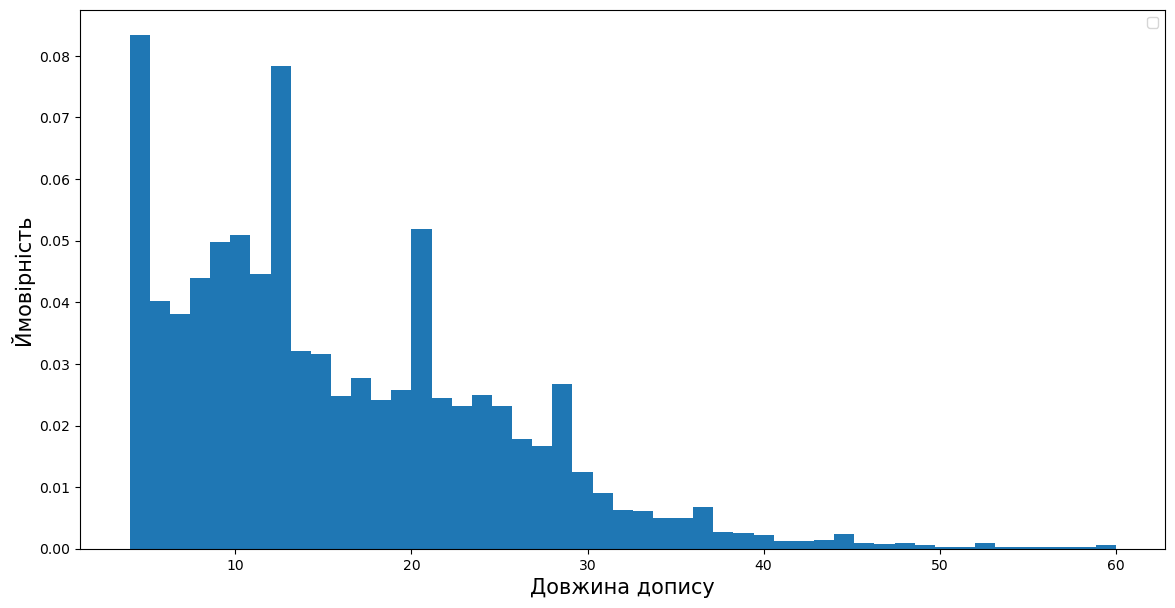

In [50]:
values = df["words_len"].values
bins = np.linspace(4, 60, 50)

fig = plt.figure(figsize = (14,7))
plt.hist(values, bins, density=True)
plt.xlabel("Довжина допису", fontsize=15)
plt.ylabel("Ймовірність", fontsize=15)
plt.legend(loc='upper right')
plt.show()

In [51]:
df["words"] = df["processed_text"].apply(lambda text: text.split(" "))

In [52]:
sns.set()
plt.rcParams['figure.figsize'] = [15, 20]

In [53]:
def draw_word_cloud():
    wordcloud = WordCloud(background_color="white", contour_width=0.1, scale=1,
                      contour_color="black",  max_font_size=150, random_state=42,
                      colormap="Dark2")
    for i, label_name in zip(range(10), np.unique(df['max_reactions_category'])):
        df_part = df[df['max_reactions_category'] == label_name]
        words = df_part['words']
        allwords = []
        for wordlist in words:
            allwords += wordlist

        mostcommon = FreqDist(allwords).most_common(100)

        wordcloud.generate(text=str(mostcommon))   
        plt.subplot(5, 2, i+1)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(label_name, fontsize=15)
    plt.show()

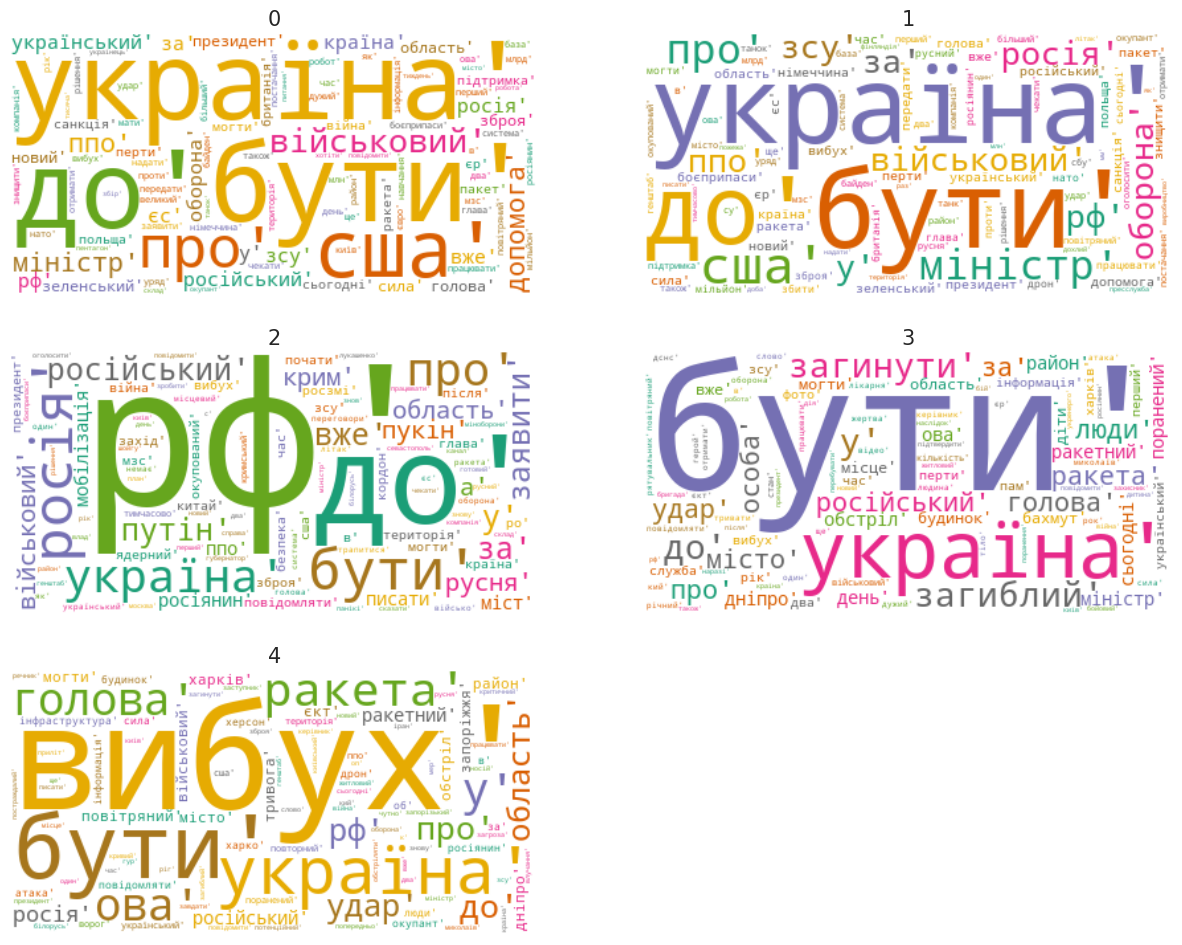

In [54]:
draw_word_cloud()

<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax">ID</th>
    <th class="tg-0lax"><span style="font-weight:400;font-style:normal">Reaction</span></th>
  </tr>
</thead>
<tbody>
  <tr>
    <th class="tg-0lax">0</th>
    <th class="tg-0lax"><span style="font-weight:400;font-style:normal">❤</span></th>
  </tr>
  <tr>
    <td class="tg-0lax">1</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">🔥</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">2</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">😁</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">3</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">😢</span></td>
  </tr>
  <tr>
    <td class="tg-0lax">4</td>
    <td class="tg-0lax"><span style="font-weight:400;font-style:normal">🤬</span></td>
  </tr>
</tbody>
</table>

In [55]:
words_to_drop = ["до", "бути", "україна", "що", "про", "у", "в", "п", "сша", "військовий", "міністр", "рф"]
# words_to_drop = []
def drop_words_by_hands(words):
    for word_to_drop in words_to_drop:
        if word_to_drop in words:
            words.remove(word_to_drop)
    return words

In [56]:
df["words"] = df["words"].apply(drop_words_by_hands)

In [57]:
df["words"]

11778    [неефективний, робота, луганський, ппо, успішн...
2686     [уряд, сербія, вирішити, направити, гуманітарн...
427      [чехія, ще, маяти, обладнання, могти, передани...
9525     [європа, завчасно, наблизитися, мета, зберіган...
10932    [арештувати, актив, компанія, білорусь, мільяр...
                               ...                        
11308    [бахмутом, росіянин, проводити, штурм, іти, бі...
1010     [процес, постачання, винищувач, зрушити, місце...
9622                                        [вибух, харко]
1727     [пвк, вагнер, зазнати, втрата, джон, кірбий, з...
2574     [весна, початок, літо, вирішальний, війна, пре...
Name: words, Length: 11842, dtype: object

## Проектування ознак
На початку аналізу тексту, налаштуємо механізм вилучення ознак за методом n-gram

In [58]:
test_tokenization_message = "Гетьте думи ви хмари осінні"
words = nltk.word_tokenize(test_tokenization_message)

In [59]:
bigrams = nltk.ngrams(df["words"][2], n=2)

In [60]:
bigram_fdist = nltk.FreqDist(bigrams)

In [61]:
bigram_fdist.most_common(5)

[(('український', 'відбити'), 1),
 (('відбити', 'атака'), 1),
 (('атака', 'доба'), 1),
 (('доба', 'бахмутське'), 1),
 (('бахмутське', 'авдіївський'), 1)]

## Розділ вибірки на тренувальну, валідаційну та тестову
Розділ відбувається за такими правилами: 
* 20% - тестова вибірка
* 20% - валідаційна вибірка
* 60% - тренувальна вибірка

In [62]:
df_train, df_test = train_test_split(df, test_size=0.2, train_size=0.8)
df_train, df_val = train_test_split(df_train, test_size=0.25, train_size=0.75)

for tensorflow

In [63]:
df_train, df_test = train_test_split(df, test_size=0.2, train_size=0.8)

In [64]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9473 entries, 9915 to 10540
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  9473 non-null   int64  
 1   peer_id                             9473 non-null   int64  
 2   date                                9473 non-null   object 
 3   message                             9454 non-null   object 
 4   out                                 9473 non-null   bool   
 5   mentioned                           9473 non-null   bool   
 6   media_unread                        9473 non-null   bool   
 7   silent                              9473 non-null   bool   
 8   post                                9473 non-null   bool   
 9   from_scheduled                      9473 non-null   object 
 10  legacy                              9473 non-null   bool   
 11  pinned                              947

In [65]:
df_train.head(2)

,id,peer_id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,...,views,forwards,reactions,processed_text,processed_text_no_stemming,max_reaction,max_reactions_category,max_reactions_category_generalized,words,words_len
9915,17751,1536630827,"08/21/2022, 08:19:43",Українські військові знищили склади та командн...,False,False,False,False,True,False,...,457624.0,221.0,"{'❤': 19716, '🔥': 0, '😁': 573, '😢': 16, '🤬': 18}",український військовий знищити склад командний...,Українські військові знищили склади та командн...,❤,0,0,"[український, знищити, склад, командний, пункт...",29
11907,15575,1536630827,"07/11/2022, 04:38:21",На Краматорському та Бахмутському напрямках є ...,False,False,False,False,True,False,...,391456.0,345.0,"{'❤': 36, '🔥': 0, '😁': 42, '😢': 426, '🤬': 12689}",краматорський бахмутське напрямок бути ознака ...,На Краматорському та Бахмутському напрямках є ...,🤬,4,3,"[краматорський, бахмутське, напрямок, ознака, ...",12


In [66]:
NUMBER_OF_CATEGORIES = 4

In [67]:
def from_category(categories):
    y_all = []
    for category in categories:
        y_cell = np.zeros((NUMBER_OF_CATEGORIES, ), dtype=int)
        y_cell[category] = 1
        y_all.append(y_cell)
    y_all = np.array(y_all)
    return y_all

In [68]:
# y_train = from_category(df_train["max_reactions_category"])
# y_test = from_category(df_test["max_reactions_category"])

In [69]:
y_train = from_category(df_train["max_reactions_category_generalized"])
y_test = from_category(df_test["max_reactions_category_generalized"])

# Перетворення тексту в нумерований формат
Для подальшого формування вхідного вектору моделі, дані будуть перетворені у нумерований формат.

## Bag-of-Words
Побудуємо словникову ознаку на основі N слів, що найчастіше зустрічаються.

In [70]:
word_counts = {}
def build_word_counts(words):
    for word in words:
        if word not in list(word_counts.keys()):
            word_counts[word] = 1
        word_counts[word] += 1

In [71]:
_ = df_train["words"].aggregate(build_word_counts)

Проведемо ранжування слів за частотою їх появ

In [72]:
words_by_freq = sorted(word_counts, key=word_counts.get, reverse=True)

words_to_index = {key: rank for rank, key in enumerate(words_by_freq, 0)}
index_to_words = {index: word for word, index in words_to_index.items()}

In [73]:
print("Розмір словника: ", len(words_by_freq), "\n", end="")
print("Топ-10", words_by_freq[:10])

Розмір словника:  12960 
Топ-10 ['вибух', 'російський', 'росія', 'україна', 'ппо', 'ракета', 'голова', 'за', 'український', 'зсу']


### Побудова BOW
Для кожного допису створимо нульовий вектор з розмірністю N і заповнимо його відповідними словами, що зустрілися в цьому дописі

In [74]:
dict_size = len(words_by_freq)
def message_bow_vec(words, words_to_index):
    result_vec = np.zeros(dict_size)
    for word in words:
        if word in words_to_index:
            result_vec[words_to_index[word]] += 1
    return result_vec

In [75]:
X_train_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_train["words"]])
X_val_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_val["words"]])
print("Train X shape -> ", X_train_bow.shape, "\nValidation X shape -> ", X_val_bow.shape)

Train X shape ->  (9473, 12960) 
Validation X shape ->  (2369, 12960)


In [76]:
X_train_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_train["words"]])
X_test_bow = sp_sparse.vstack([sp_sparse.csr_matrix(message_bow_vec(words, words_to_index)) for words in df_test["words"]])

### TF-IDF
<i>Term frequency-inverse document frequency</i>

Ознака, мета якої відобразити наскільки важливе слово в документі в колекції корпусів тексту.
Цей метод є доповненням до Bag-of-Words, де частота слова поділена на загальну кількість слів. 

In [77]:
def tfidf_features_validation(X_train, X_val, X_test, n_gram_range=(1,4), n_gram_level="word"):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=n_gram_range, max_df=0.9, min_df=5, analyzer=n_gram_level)
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["processed_text"].to_numpy())
    X_val_tfidf = tfidf_vectorizer.transform(X_val["processed_text"].to_numpy())
    X_test_tfidf = tfidf_vectorizer.transform(X_test["processed_text"].to_numpy())
    
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

In [78]:
def tfidf_features(X_train, X_test, n_gram_range=(1,4), n_gram_level="word"):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=n_gram_range, max_df=0.9, min_df=5, analyzer=n_gram_level)
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["processed_text"].to_numpy())
    X_test_tfidf = tfidf_vectorizer.transform(X_test["processed_text"].to_numpy())
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

In [79]:
def tfidf_features_unprocessed_text(X_train, X_test, n_gram_range=(3,8), n_gram_level="char"):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=n_gram_range, max_df=0.9, min_df=5, analyzer=n_gram_level)
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["processed_text_no_stemming"].to_numpy())
    X_test_tfidf = tfidf_vectorizer.transform(X_test["processed_text_no_stemming"].to_numpy())
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

In [80]:
def tfidf_features_binary(X_train, X_test, n_gram_size):
    binary_vectorizer = 

SyntaxError: invalid syntax (1453846250.py, line 2)

### N-gram
Врахуємо n-gram модель представлення частин тексту для подальшого інтелектуального аналізу тексту.
* рівень слів та словосполучень
* рівень символів кирилиці 

#### Рівень слів та словосполучень
Оберемо плаваючий розмір вікна 4(врахування усіх вікон від 1(рівень слова) до 4(словосполучення))
Застосуємо цей метод з припущенням, що в текстах дописів будуть присутні слова та словосполучення, що матимуть певну 

In [81]:
X_train_tfidf_w, X_val_tfidf_w, X_test_tfid_w, tfidf_vocab_w = tfidf_features_validation(df_train, df_val, df_test)

for tf

In [82]:
X_train_tfidf_w, X_test_tfidf_w, tfidf_vocab_w = tfidf_features(df_train, df_test)

In [83]:
tfidf_reversed_vocab_w = {i: word for word, i in tfidf_vocab_w.items()}

#### Тільки словосполучення

In [84]:
X_train_tfidf_wg, X_test_tfidf_wg, tfidf_vocab_wg = tfidf_features(
    df_train, df_test, (2,3), "word")

#### Символьний рівень
Оберемо вікно від 3(корінь слова) до 10

In [85]:
X_train_tfidf_c, X_test_tfidf_c, tfidf_vocab_c = tfidf_features(
    df_train, df_test, (3,10), "char")

In [86]:
X_train_tfidf_c, X_test_tfidf_c, tfidf_vocab_c = tfidf_features(
    df_train, df_test, (3,5), "char")

In [87]:
tfidf_reversed_vocab_c = {i: char_seq for char_seq, i in tfidf_vocab_c.items()}
len(tfidf_reversed_vocab_c)

47049

In [88]:
X_train_tfidf_rc, X_test_tfidf_rc, _ = tfidf_features(df_train, df_test, (3,8), "char")

### Word2Vec

In [89]:
w2v = Word2Vec(df_train["words"], vector_size=1000, window=3)
w2v.wv.index_to_key[:10]

['вибух',
 'російський',
 'росія',
 'україна',
 'ппо',
 'ракета',
 'голова',
 'за',
 'український',
 'зсу']

Переглянемо слова що більше за інші зустрічаються в контексті зі словом "росія" 

In [90]:
w2v.wv.most_similar("росія")

[('війна', 0.9997212886810303),
 ('рішення', 0.999662458896637),
 ('ухвалити', 0.9996310472488403),
 ('постачання', 0.9996219873428345),
 ('оголосити', 0.9995844960212708),
 ('ввести', 0.9995554685592651),
 ('іран', 0.9995478987693787),
 ('більший', 0.9995457530021667),
 ('запровадити', 0.9995421171188354),
 ('зброя', 0.9995375871658325)]

In [91]:
w2v_words = set(w2v.wv.index_to_key)
X_train_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words]) 
                        for corpus in df_train["words"]])
X_test_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words]) 
                       for corpus in df_test["words"]])

/tmp/ipykernel_4139/3204335971.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words])
/tmp/ipykernel_4139/3204335971.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_w2v = np.array([np.array([w2v.wv[word] for word in corpus if word in w2v_words])


In [92]:
df_train["words"]

9915     [український, знищити, склад, командний, пункт...
11907    [краматорський, бахмутське, напрямок, ознака, ...
4598     [ворог, вже, часто, дозволяти, себе, масований...
4481     [норвегія, приєднатися, стеля, ціна, російськи...
5267     [кінбурнський, коса, миколаївщина, зосереджува...
                               ...                        
318      [росія, почати, кидати, бахмут, елітний, підро...
1121     [грузинський, опозиція, оголосити, новий, прот...
3956     [путін, зазнати, поразка, вже, зазнати, поразк...
10840                              [новий, каховка, зараз]
10540    [єс, засудити, ведення, росія, воєнний, діяльн...
Name: words, Length: 9473, dtype: object

In [93]:
def show_shape(X):    
    for i, v in enumerate(X):
        if i < 10:
            print(len(df_train["words"].iloc[i]), len(v))

In [94]:
X_train_w2v_avg = []
for word_vec in X_train_w2v:
    if word_vec.size:
        X_train_w2v_avg.append(word_vec.max(axis=0))
    else:
        X_train_w2v_avg.append(np.zeros(1000, dtype=float))
        
X_test_w2v_avg = []
for word_vec in X_test_w2v:
    if word_vec.size:
        X_test_w2v_avg.append(word_vec.mean(axis=0))
    else:
        X_test_w2v_avg.append(np.zeros(1000, dtype=float))

# Мульти-класова класифікація
Для побудови вирішення задачі класифікації буде використана сигмоїдна функція. Стратегія складається у побудові одного класифікатора для одного класу. Для кожного класифікатора клас порівнюється з усіма іншими класами.

In [95]:
def plot_learning_metrics(result, title, epochs=15):
    accuracy_percentage = np.round(100 * result.history["accuracy"][-1], 3) 
    print(f"TRAIN Accuracy: {accuracy_percentage}% \n")
    
    x_range = range(epochs)
    
    fig, (loss_plt, accuracy_plt) = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
    
    loss_plt.plot(x_range, result.history["loss"], "r", label="TRAIN loss")
    loss_plt.plot(x_range, result.history["val_loss"], "g", label="TEST loss")
    loss_plt.legend()
    
    accuracy_plt.plot(x_range, result.history["accuracy"], "b", label="TRAIN accuracy")
    accuracy_plt.plot(x_range, result.history["val_accuracy"], "lightgreen", label="TEST accuracy")
    accuracy_plt.legend()
    
    plt.suptitle(f"TRAIN and TEST metrics -> {title}")
    
    fig.tight_layout()
    plt.show()

In [96]:
def false_negative(confusion_matrix, category_index):
    return np.sum(np.delete(confusion_matrix[category_index, :], category_index))

In [97]:
def false_positive(confusion_matrix, category_index):
    return np.sum(np.delete(confusion_matrix[:, category_index], category_index))

In [98]:
def true_negative(confusion_matrix, category_index):
    middle_step = np.delete(confusion_matrix, category_index, 0)
    middle_step = np.delete(middle_step, category_index, 1)
    return np.sum(middle_step)

In [99]:
def count_frr_far(confusion_matrix):
    metrics = {}
    category_count = confusion_matrix.shape[0]
    for category in range(category_count):
        tp = confusion_matrix[category][category]
        tn = true_negative(confusion_matrix, category)
        
        fn = false_negative(confusion_matrix, category)
        fp = false_positive(confusion_matrix, category)
        
        frr_value = fn / (fn + tp)
        far_value = fp / (fp + tn)
        
        metrics[category] = {"frr": frr_value, "far": far_value}
    return metrics

In [100]:
def show_confusion_matrix(y_true, y_pred):
    categories = list(range(np.max(y_true)))
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
#     cm_display.plot()
#     plt.figure().set_figheight(10).set_figwidth(10)
#     plt.show()
    
    return confusion_matrix

In [101]:
def model_and_report(model_foo, model_fit_result, X_test, y_test, model_name="", verbose=False):
    y_pred = model_foo.predict(X_test)
    _, accuracy = model_foo.evaluate(X_test, y_test, verbose=verbose)
    
    print(f"MODEL: {model_name}")
    print(f"On TEST accuracy: {accuracy}")
    plot_learning_metrics(model_fit_result, model_name)
    confusion_matrix = np.array(
        show_confusion_matrix(y_test.argmax(axis=1), np.argmax(y_pred, axis=1)))
    print("\n\nCONFUSION MATRIX: ")
    print(confusion_matrix)
    
    print("\n\nREPORT: ")
    print(metrics.classification_report(y_test.argmax(axis=1), np.argmax(y_pred, axis=1)))

    print("\n FRR and FAR: ")
    print(json.dumps(count_frr_far(confusion_matrix), indent=2))

In [102]:
def get_metrics_table(method_name, accuracy, f1_score, precision, recall, far, frr):
    metrics_table_html = f"""
        <table>
            <thead>
                <tr>
                    <td>Method name</td>
                    <td>Accuracy</td>
                    <td>F-Score</td>
                    <td>Precision</td>
                    <td>Recall</td>
                    <td>FAR</td>
                    <td>FRR</td>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td><strong>{method_name}</strong></td>
                    <td>{accuracy}</td>
                    <td>{f1_score}</td>
                    <td>{precision}</td>
                    <td>{recall}</td>
                    <td>{far}</td>
                    <td>{frr}</td>
                </tr>
            </tbody>
        </table>
    """
    return metrics_table_html

In [103]:
display(HTML(get_metrics_table("BOW", 0, 1, 2, 3, 4, 5)))

Method name,Accuracy,F-Score,Precision,Recall,FAR,FRR
BOW,0,1,2,3,4,5


In [104]:
OUT = NUMBER_OF_CATEGORIES
BATCH_SIZE = 64
EPOCHS = 15

In [105]:
def fit_learning_rate(model_function, l, train_data, model_name):
    (X_train, y_train) = train_data
    learning_rates = [10 ** (-i) for i in range(1, l+1)]
    
    for current_rate in learning_rates:
        model = model_function(learning_rate=current_rate)
        
        result = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=False)
        
        print(f"learning rate -> {current_rate}")
        plot_learning_metrics(result, model_name)

## Одношаровий Softmax 
Архітектура моделі

In [108]:
def single_layer_softmax_model(input_shape, learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(input_shape[1],)),
        tf.keras.layers.Dense(OUT, 
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1.0), 
#                               kernel_regularizer="l2",
                              activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

### BOW

In [109]:
softmax_simple_bow = single_layer_softmax_model(X_train_bow.toarray().shape)
softmax_simple_bow_result = softmax_simple_bow.fit(
    X_train_bow.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=False)

75/75 [==============================] - 0s 712us/step
MODEL: SOFTMAX - BOW
On TEST accuracy: 0.6365554928779602
TRAIN Accuracy: 68.356% 



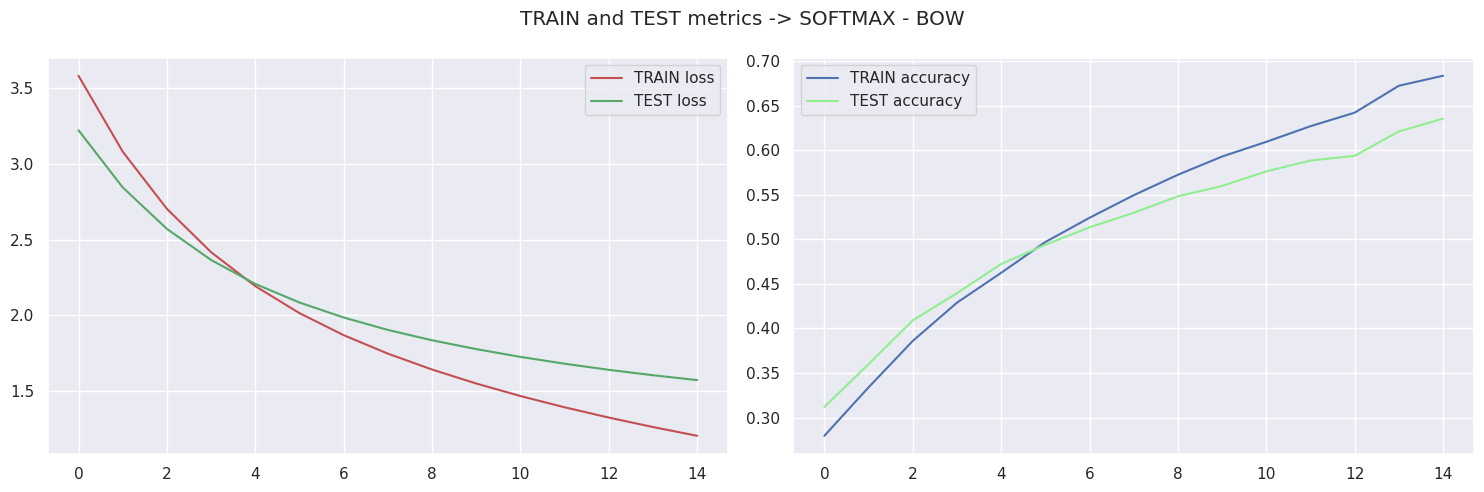



CONFUSION MATRIX: 
[[1271   72   59  210]
 [  89    7    7   25]
 [  49    6   11   35]
 [ 250   33   26  219]]


REPORT: 
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1612
           1       0.06      0.05      0.06       128
           2       0.11      0.11      0.11       101
           3       0.45      0.41      0.43       528

    accuracy                           0.64      2369
   macro avg       0.35      0.34      0.34      2369
weighted avg       0.63      0.64      0.63      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.21153846153846154,
    "far": 0.512549537648613
  },
  "1": {
    "frr": 0.9453125,
    "far": 0.049531459170013385
  },
  "2": {
    "frr": 0.8910891089108911,
    "far": 0.04056437389770723
  },
  "3": {
    "frr": 0.5852272727272727,
    "far": 0.14665942422596415
  }
}


In [159]:
model_and_report(softmax_simple_bow, softmax_simple_bow_result, X_test_bow.toarray(), y_test, "SOFTMAX - BOW")

### TF-IDF words n-gram sequences

In [162]:
softmax_simple_tfidf_w = single_layer_softmax_model(X_train_tfidf_w.toarray().shape)
softmax_simple_tfidf_w_result = softmax_simple_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

75/75 [==============================] - 0s 621us/step
MODEL: SOFTMAX - TFIDF + n-gram words(1,4)
On TEST accuracy: 0.7252005338668823
TRAIN Accuracy: 75.746% 



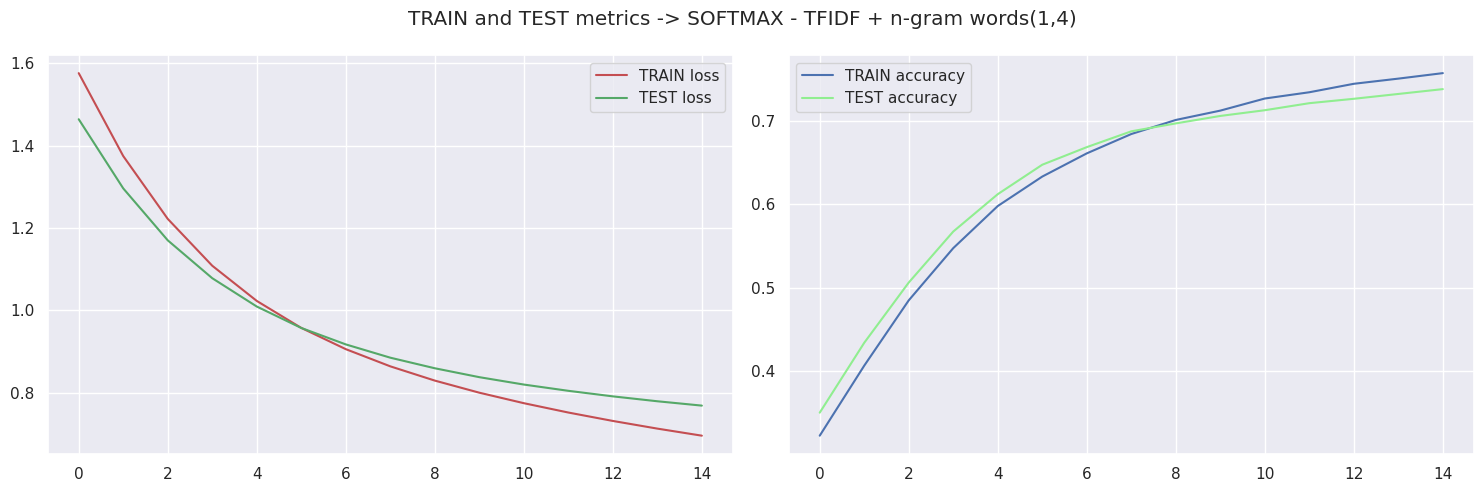



CONFUSION MATRIX: 
[[1462   17   11  122]
 [ 111    1    1   15]
 [  62    2    6   31]
 [ 271    2    6  249]]


REPORT: 
              precision    recall  f1-score   support

           0       0.77      0.91      0.83      1612
           1       0.05      0.01      0.01       128
           2       0.25      0.06      0.10       101
           3       0.60      0.47      0.53       528

    accuracy                           0.73      2369
   macro avg       0.41      0.36      0.37      2369
weighted avg       0.67      0.73      0.69      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.09305210918114144,
    "far": 0.5865257595772787
  },
  "1": {
    "frr": 0.9921875,
    "far": 0.009370816599732263
  },
  "2": {
    "frr": 0.9405940594059405,
    "far": 0.007936507936507936
  },
  "3": {
    "frr": 0.5284090909090909,
    "far": 0.09125475285171103
  }
}


In [163]:
model_and_report(softmax_simple_tfidf_w, 
                 softmax_simple_tfidf_w_result, 
                 X_test_tfidf_w.toarray(), 
                 y_test, 
                 "SOFTMAX - TFIDF + n-gram words(1,4)")

### TF-IDF char n-grams

In [165]:
softmax_simple_tfidf_c = single_layer_softmax_model(X_train_tfidf_c.toarray().shape)
softmax_simple_tfidf_c_result = softmax_simple_tfidf_c.fit(
    X_train_tfidf_c.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

75/75 [==============================] - 0s 1ms/step
MODEL: SOFTMAX - TFIDF + n-gram chars(3,5)
On TEST accuracy: 0.7728999853134155
TRAIN Accuracy: 84.323% 



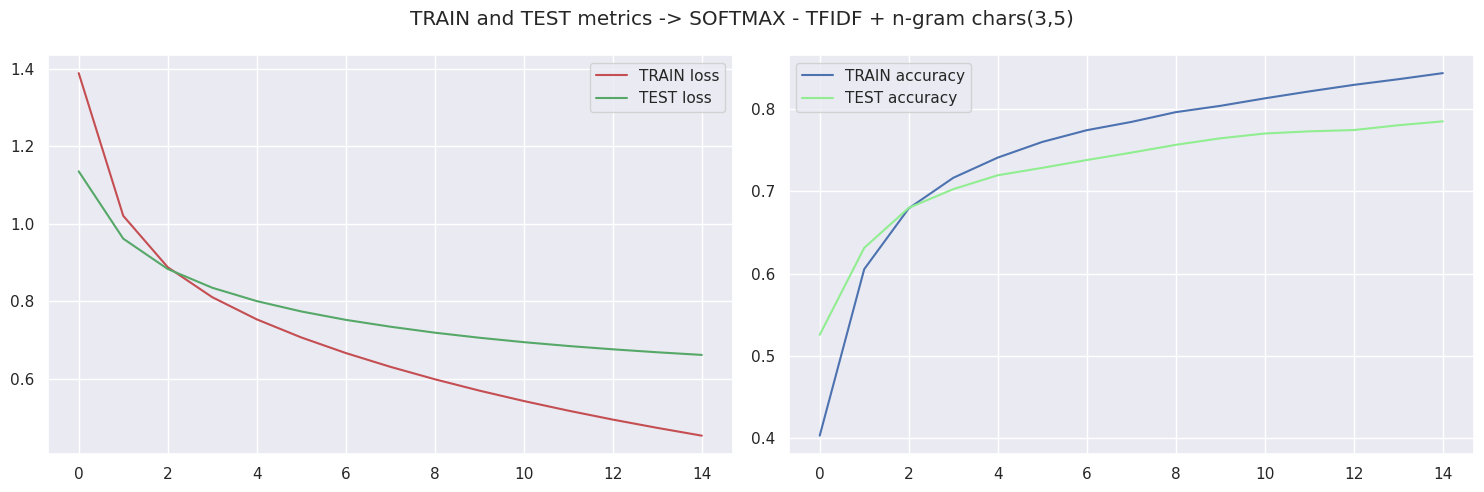



CONFUSION MATRIX: 
[[1489   23   10   90]
 [  97   17    2   12]
 [  58    0   12   31]
 [ 200    6    9  313]]


REPORT: 
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1612
           1       0.37      0.13      0.20       128
           2       0.36      0.12      0.18       101
           3       0.70      0.59      0.64       528

    accuracy                           0.77      2369
   macro avg       0.56      0.44      0.47      2369
weighted avg       0.74      0.77      0.75      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.07630272952853598,
    "far": 0.46895640686922063
  },
  "1": {
    "frr": 0.8671875,
    "far": 0.012940651494868362
  },
  "2": {
    "frr": 0.8811881188118812,
    "far": 0.009259259259259259
  },
  "3": {
    "frr": 0.4071969696969697,
    "far": 0.07224334600760456
  }
}


In [166]:
model_and_report(softmax_simple_tfidf_c, 
                 softmax_simple_tfidf_c_result, 
                 X_test_tfidf_c.toarray(), 
                 y_test, 
                 "SOFTMAX - TFIDF + n-gram chars(3,5)")

### Word2Vec

In [168]:
softmax_simple_w2v = single_layer_softmax_model(np.array(X_train_w2v_avg).shape)
softmax_simple_w2v_result = softmax_simple_w2v.fit(
    np.array(X_train_w2v_avg), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

75/75 [==============================] - 0s 501us/step
MODEL: SOFTMAX - WORD2VEC
On TEST accuracy: 0.7209793329238892
TRAIN Accuracy: 73.383% 



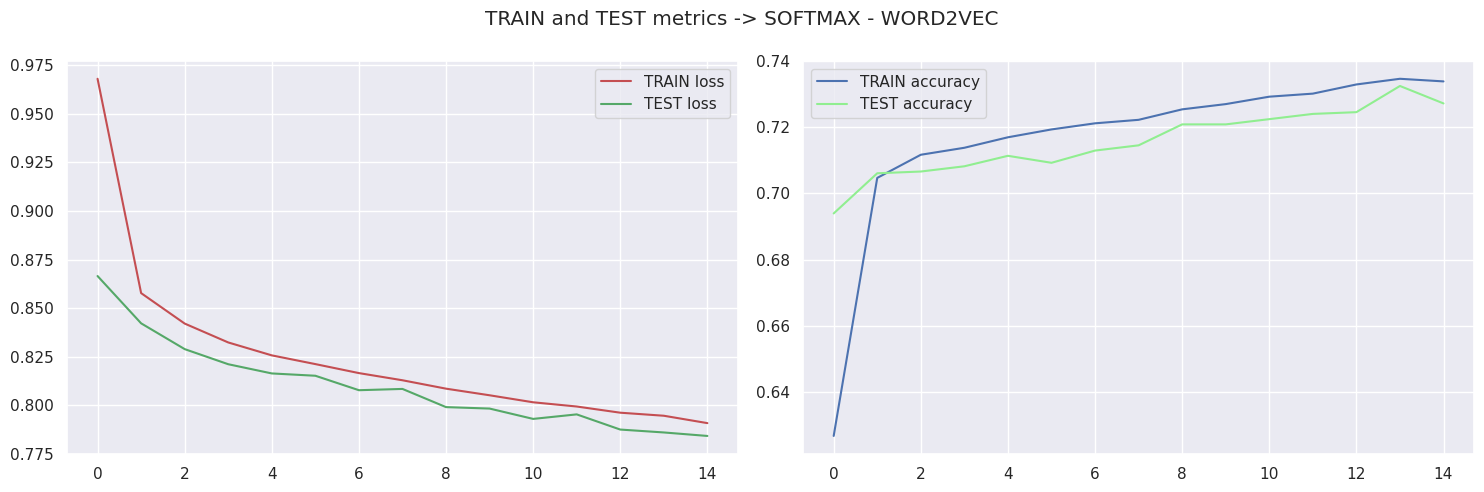



CONFUSION MATRIX: 
[[1544    0    0   68]
 [ 128    0    0    0]
 [ 101    0    0    0]
 [ 364    0    0  164]]


REPORT: 
              precision    recall  f1-score   support

           0       0.72      0.96      0.82      1612
           1       0.00      0.00      0.00       128
           2       0.00      0.00      0.00       101
           3       0.71      0.31      0.43       528

    accuracy                           0.72      2369
   macro avg       0.36      0.32      0.31      2369
weighted avg       0.65      0.72      0.66      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.04218362282878412,
    "far": 0.7833553500660502
  },
  "1": {
    "frr": 1.0,
    "far": 0.0
  },
  "2": {
    "frr": 1.0,
    "far": 0.0
  },
  "3": {
    "frr": 0.6893939393939394,
    "far": 0.036936447582835416
  }
}


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [169]:
model_and_report(softmax_simple_w2v, 
                 softmax_simple_w2v_result, 
                 np.array(X_test_w2v_avg), 
                 y_test, 
                 "SOFTMAX - WORD2VEC")

### N-gram word groups

In [104]:
# X_train_tfidf_wg, X_test_tfidf_wg
softmax_simple_tfidf_wg = single_layer_softmax_model(X_train_tfidf_wg.toarray().shape)
softmax_simple_tfidf_wg_result = softmax_simple_tfidf_wg.fit(
    X_train_tfidf_wg.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

75/75 [==============================] - 0s 611us/step
MODEL: SOFTMAX - WORD GROUPS
On TEST accuracy: 0.6745462417602539
TRAIN Accuracy: 69.029% 



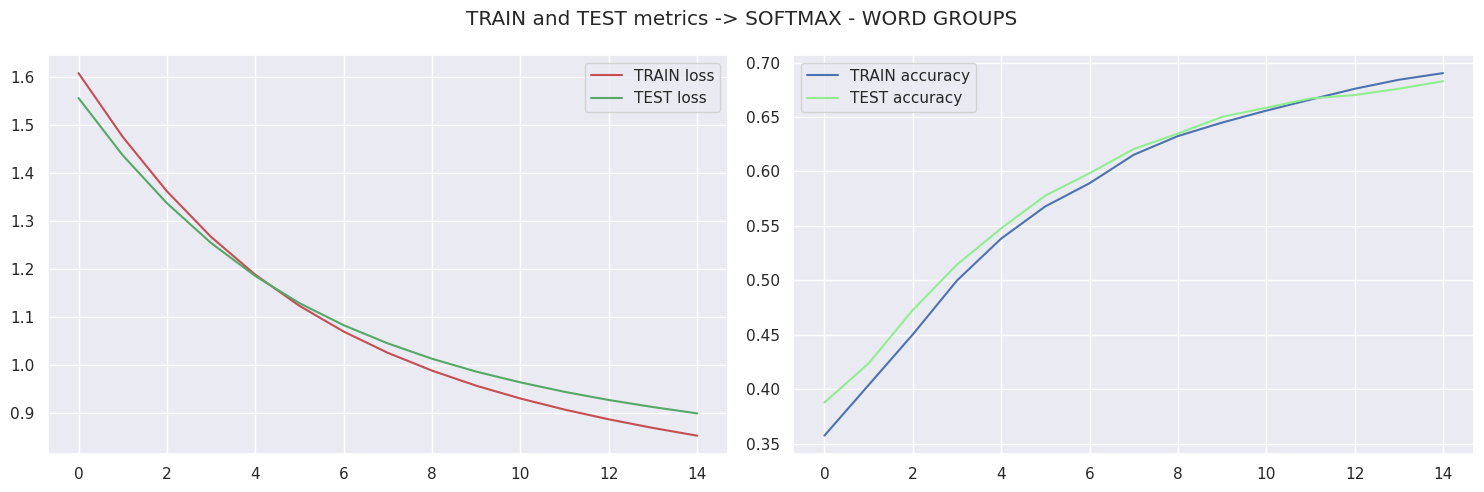



CONFUSION MATRIX: 
[[1456   20   12  124]
 [ 117    1    1    9]
 [  88    1    2   10]
 [ 368    6   15  139]]


REPORT: 
              precision    recall  f1-score   support

           0       0.72      0.90      0.80      1612
           1       0.04      0.01      0.01       128
           2       0.07      0.02      0.03       101
           3       0.49      0.26      0.34       528

    accuracy                           0.67      2369
   macro avg       0.33      0.30      0.30      2369
weighted avg       0.60      0.67      0.62      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.0967741935483871,
    "far": 0.7569352708058125
  },
  "1": {
    "frr": 0.9921875,
    "far": 0.012048192771084338
  },
  "2": {
    "frr": 0.9801980198019802,
    "far": 0.012345679012345678
  },
  "3": {
    "frr": 0.7367424242424242,
    "far": 0.07767517653449213
  }
}


In [170]:
model_and_report(softmax_simple_tfidf_wg, 
                 softmax_simple_tfidf_wg_result, 
                 X_test_tfidf_wg.toarray(), 
                 y_test, 
                 "SOFTMAX - WORD GROUPS")

## Multi-layer deep neural network

In [110]:
def deep_multilayer_model(input_shape, learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(input_shape[1],)),
#         tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1.0),
                              kernel_regularizer="l2",
                              activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256,
#                               kernel_regularizer="l2",
                              activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(# Adam + crossentropy
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

### BOW

In [111]:
multi_layer_bow = deep_multilayer_model(X_train_bow.toarray().shape)
multi_layer_bow_result = multi_layer_bow.fit(
    X_train_bow.toarray(),
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=False)

75/75 [==============================] - 0s 5ms/step
MODEL: MULTI-LAYER - BOW
On TEST accuracy: 0.745884358882904
TRAIN Accuracy: 97.48% 



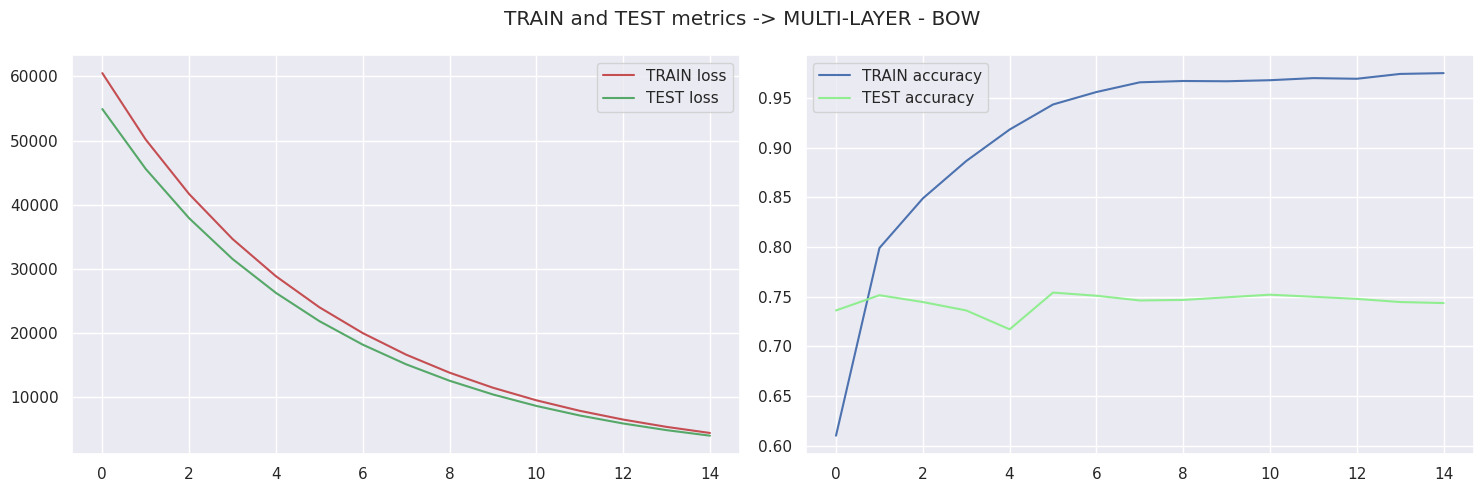



CONFUSION MATRIX: 
[[1442   53   22  116]
 [ 114   17    1   19]
 [  47    5   11   19]
 [ 183   10   13  297]]


REPORT: 
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1633
           1       0.20      0.11      0.14       151
           2       0.23      0.13      0.17        82
           3       0.66      0.59      0.62       503

    accuracy                           0.75      2369
   macro avg       0.47      0.43      0.45      2369
weighted avg       0.72      0.75      0.73      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.11696264543784446,
    "far": 0.4673913043478261
  },
  "1": {
    "frr": 0.8874172185430463,
    "far": 0.030658250676284943
  },
  "2": {
    "frr": 0.8658536585365854,
    "far": 0.015741145605596852
  },
  "3": {
    "frr": 0.4095427435387674,
    "far": 0.08252947481243302
  }
}


In [112]:
model_and_report(multi_layer_bow, 
                 multi_layer_bow_result, 
                 X_test_bow.toarray(), 
                 y_test, 
                 "MULTI-LAYER - BOW")

### TFIDF n-gram words 

In [114]:
deep_multilayer_model_tfidf_w = deep_multilayer_model(X_train_tfidf_w.toarray().shape)
deep_multilayer_model_tfidf_w_result = deep_multilayer_model_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

75/75 [==============================] - 0s 3ms/step
MODEL: MULTI-LAYER - TF-IDF WORD n-gram
On TEST accuracy: 0.7467285990715027
TRAIN Accuracy: 97.809% 



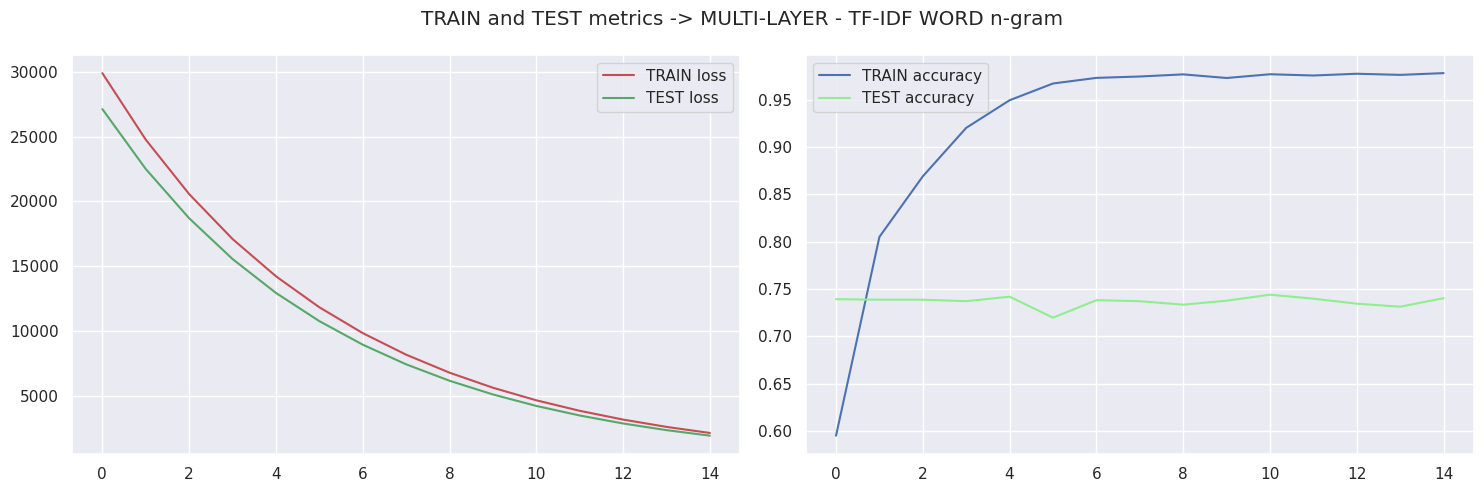



CONFUSION MATRIX: 
[[1488   33   10  102]
 [ 114   15    3   19]
 [  47    4    8   23]
 [ 223    7   15  258]]


REPORT: 
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1633
           1       0.25      0.10      0.14       151
           2       0.22      0.10      0.14        82
           3       0.64      0.51      0.57       503

    accuracy                           0.75      2369
   macro avg       0.48      0.41      0.42      2369
weighted avg       0.71      0.75      0.72      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.08879363135333741,
    "far": 0.5217391304347826
  },
  "1": {
    "frr": 0.9006622516556292,
    "far": 0.019837691614066726
  },
  "2": {
    "frr": 0.9024390243902439,
    "far": 0.012243113248797552
  },
  "3": {
    "frr": 0.4870775347912525,
    "far": 0.07717041800643087
  }
}


In [115]:
model_and_report(deep_multilayer_model_tfidf_w, 
                 deep_multilayer_model_tfidf_w_result, 
                 X_test_tfidf_w.toarray(), 
                 y_test, 
                 "MULTI-LAYER - TF-IDF WORD n-gram")

### TF-IDF Char n-grams

In [118]:
softmax_simple_tfidf_c = deep_multilayer_model(X_train_tfidf_c.toarray().shape)
softmax_simple_tfidf_c_result = softmax_simple_tfidf_c.fit(
    X_train_tfidf_c.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

Epoch 1/15
119/119 [==============================] - 22s 177ms/step - loss: 219727.9375 - accuracy: 0.5924 - val_loss: 199400.5000 - val_accuracy: 0.7404
Epoch 2/15
119/119 [==============================] - 20s 170ms/step - loss: 182123.2812 - accuracy: 0.8065 - val_loss: 165519.2188 - val_accuracy: 0.7530
Epoch 3/15
119/119 [==============================] - 20s 171ms/step - loss: 151316.4062 - accuracy: 0.8683 - val_loss: 137634.3750 - val_accuracy: 0.7478
Epoch 4/15
119/119 [==============================] - 20s 170ms/step - loss: 125886.1406 - accuracy: 0.9247 - val_loss: 114552.0703 - val_accuracy: 0.7456
Epoch 5/15
119/119 [==============================] - 21s 172ms/step - loss: 104795.5547 - accuracy: 0.9646 - val_loss: 95374.0312 - val_accuracy: 0.7525
Epoch 6/15
119/119 [==============================] - 21s 175ms/step - loss: 87250.1484 - accuracy: 0.9773 - val_loss: 79400.2031 - val_accuracy: 0.7467
Epoch 7/15
119/119 [==============================] - 20s 172ms/step - lo

75/75 [==============================] - 1s 16ms/step
MODEL: MULTI-LAYER - CHAR N-GRAMS
On TEST accuracy: 0.7463064789772034
TRAIN Accuracy: 98.311% 



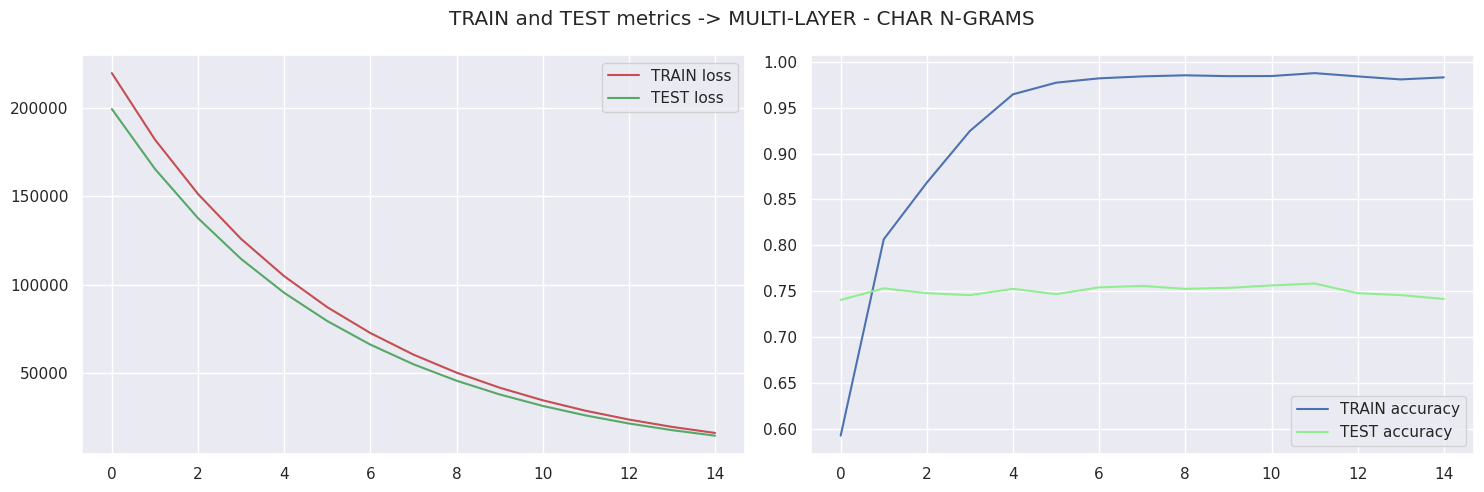



CONFUSION MATRIX: 
[[1467   34   10  122]
 [ 117   18    0   16]
 [  56    1    2   23]
 [ 212    4    6  281]]


REPORT: 
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1633
           1       0.32      0.12      0.17       151
           2       0.11      0.02      0.04        82
           3       0.64      0.56      0.59       503

    accuracy                           0.75      2369
   macro avg       0.46      0.40      0.41      2369
weighted avg       0.70      0.75      0.72      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.10165339865278629,
    "far": 0.5230978260869565
  },
  "1": {
    "frr": 0.8807947019867549,
    "far": 0.0175834084761046
  },
  "2": {
    "frr": 0.975609756097561,
    "far": 0.006996064713598601
  },
  "3": {
    "frr": 0.441351888667992,
    "far": 0.08628081457663452
  }
}


In [120]:
model_and_report(softmax_simple_tfidf_c, 
                 softmax_simple_tfidf_c_result, 
                 X_test_tfidf_c.toarray(), 
                 y_test, 
                 "MULTI-LAYER - CHAR N-GRAMS")

### Word2Vec

In [121]:
deep_multilayer_model_w2v = deep_multilayer_model(np.array(X_train_w2v_avg).shape)
deep_multilayer_model_w2v_result = deep_multilayer_model_w2v.fit(
    np.array(X_train_w2v_avg), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

Epoch 1/15
119/119 [==============================] - 1s 6ms/step - loss: 4660.6665 - accuracy: 0.6704 - val_loss: 4229.1152 - val_accuracy: 0.7351
Epoch 2/15
119/119 [==============================] - 1s 6ms/step - loss: 3862.3650 - accuracy: 0.7415 - val_loss: 3509.8987 - val_accuracy: 0.7551
Epoch 3/15
119/119 [==============================] - 1s 6ms/step - loss: 3208.4473 - accuracy: 0.7451 - val_loss: 2918.0498 - val_accuracy: 0.7499
Epoch 4/15
119/119 [==============================] - 1s 6ms/step - loss: 2668.7341 - accuracy: 0.7498 - val_loss: 2428.2285 - val_accuracy: 0.7520
Epoch 5/15
119/119 [==============================] - 1s 6ms/step - loss: 2221.2280 - accuracy: 0.7484 - val_loss: 2021.3223 - val_accuracy: 0.7551
Epoch 6/15
119/119 [==============================] - 1s 6ms/step - loss: 1848.9905 - accuracy: 0.7527 - val_loss: 1682.5043 - val_accuracy: 0.7340
Epoch 7/15
119/119 [==============================] - 1s 6ms/step - loss: 1538.7423 - accuracy: 0.7503 - val_los

75/75 [==============================] - 0s 1ms/step
MODEL: MULTI-LAYER - WORD2VEC
On TEST accuracy: 0.7357534766197205
TRAIN Accuracy: 74.611% 



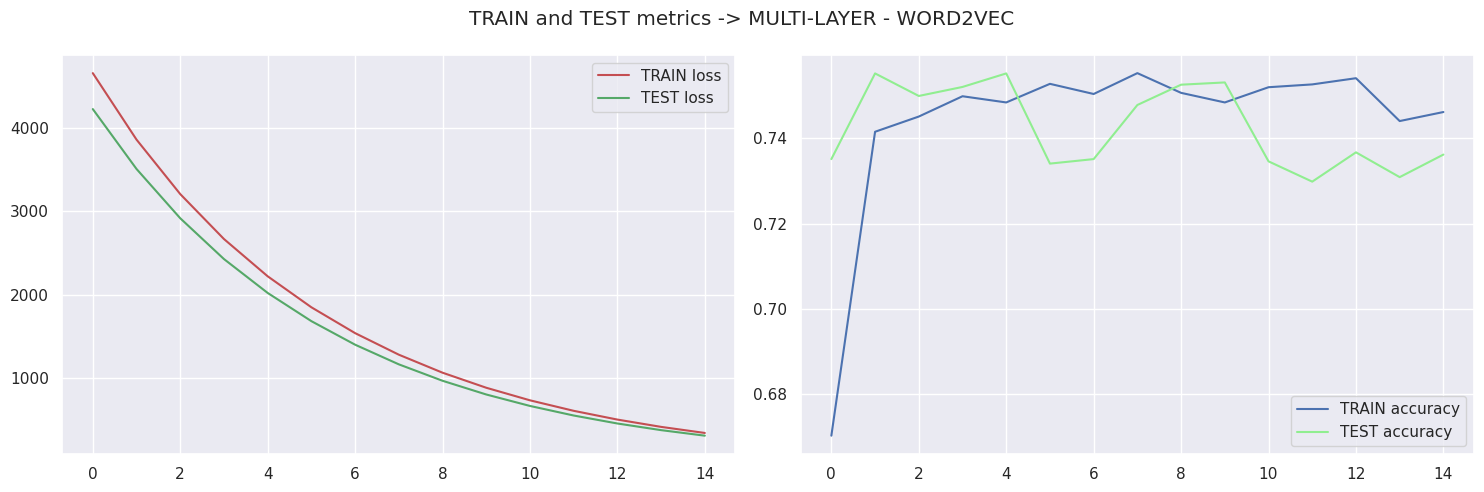



CONFUSION MATRIX: 
[[1584   31    0   18]
 [ 144    6    0    1]
 [  79    1    0    2]
 [ 344    6    0  153]]


REPORT: 
              precision    recall  f1-score   support

           0       0.74      0.97      0.84      1633
           1       0.14      0.04      0.06       151
           2       0.00      0.00      0.00        82
           3       0.88      0.30      0.45       503

    accuracy                           0.74      2369
   macro avg       0.44      0.33      0.34      2369
weighted avg       0.70      0.74      0.68      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.030006123698714023,
    "far": 0.7703804347826086
  },
  "1": {
    "frr": 0.9602649006622517,
    "far": 0.017132551848512173
  },
  "2": {
    "frr": 1.0,
    "far": 0.0
  },
  "3": {
    "frr": 0.6958250497017893,
    "far": 0.011254019292604502
  }
}


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [124]:
model_and_report(deep_multilayer_model_w2v, 
                 deep_multilayer_model_w2v_result, 
                 np.array(X_test_w2v_avg), 
                 y_test, 
                 "MULTI-LAYER - WORD2VEC")

#### With generalized dataset

## Multi-layer model with dropout regularization

In [128]:
def deep_multilayer_with_dropout_model(input_shape, learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(#loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
        loss="categorical_crossentropy",
        metrics=["accuracy"])
    
    return model

### BOW

In [131]:
multi_layer_dropout_bow = deep_multilayer_with_dropout_model(X_train_bow.toarray().shape)
multi_layer_dropout_bow_result = multi_layer_dropout_bow.fit(
    X_train_bow.toarray(),
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=True)

Epoch 1/15
119/119 [==============================] - 9s 28ms/step - loss: 7.8159 - accuracy: 0.5765 - val_loss: 6.6811 - val_accuracy: 0.6681
Epoch 2/15
119/119 [==============================] - 3s 28ms/step - loss: 5.9047 - accuracy: 0.7651 - val_loss: 5.3575 - val_accuracy: 0.7309
Epoch 3/15
119/119 [==============================] - 3s 27ms/step - loss: 4.6180 - accuracy: 0.7936 - val_loss: 4.3735 - val_accuracy: 0.7462
Epoch 4/15
119/119 [==============================] - 3s 28ms/step - loss: 3.6399 - accuracy: 0.8290 - val_loss: 3.5583 - val_accuracy: 0.7873
Epoch 5/15
119/119 [==============================] - 3s 27ms/step - loss: 3.0291 - accuracy: 0.8455 - val_loss: 3.1227 - val_accuracy: 0.7704
Epoch 6/15
119/119 [==============================] - 3s 26ms/step - loss: 2.6549 - accuracy: 0.8645 - val_loss: 2.9992 - val_accuracy: 0.7414
Epoch 7/15
119/119 [==============================] - 3s 26ms/step - loss: 2.4782 - accuracy: 0.8684 - val_loss: 3.0090 - val_accuracy: 0.7034

75/75 [==============================] - 1s 6ms/step
MODEL: MULTI-LAYER + DROPOUT - BOW
On TEST accuracy: 0.6986070275306702
TRAIN Accuracy: 87.952% 



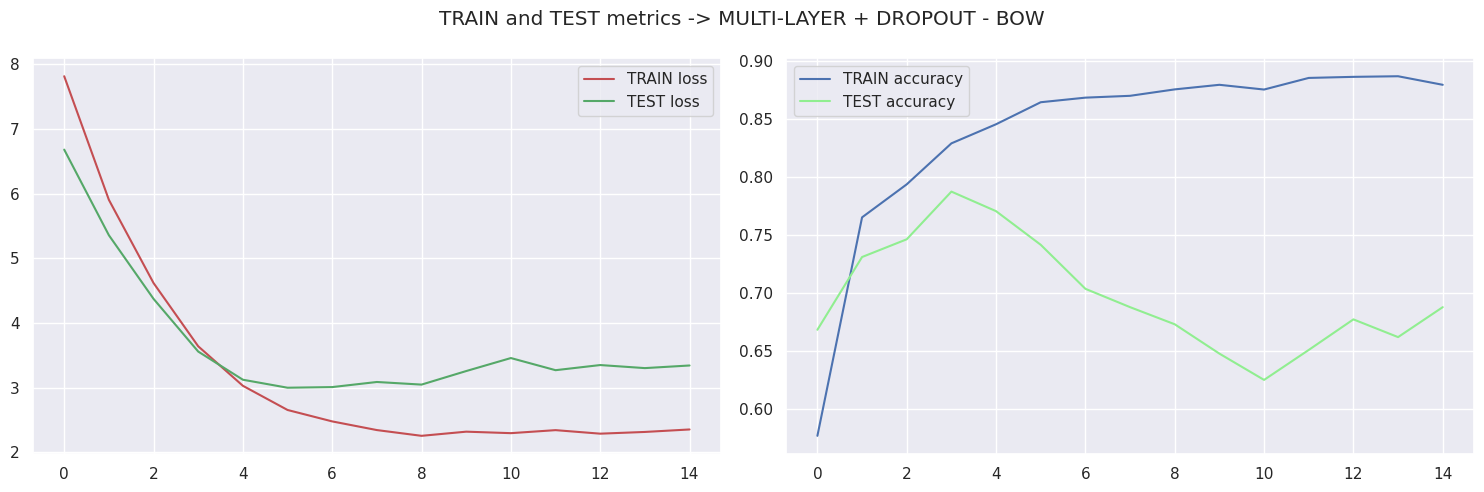



CONFUSION MATRIX: 
[[1196   80   80  277]
 [  60   43    7   41]
 [  16    1   27   38]
 [  77   11   26  389]]


REPORT: 
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1633
           1       0.32      0.28      0.30       151
           2       0.19      0.33      0.24        82
           3       0.52      0.77      0.62       503

    accuracy                           0.70      2369
   macro avg       0.48      0.53      0.49      2369
weighted avg       0.75      0.70      0.71      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.2676056338028169,
    "far": 0.2078804347826087
  },
  "1": {
    "frr": 0.7152317880794702,
    "far": 0.04147880973850315
  },
  "2": {
    "frr": 0.6707317073170732,
    "far": 0.04940970703979012
  },
  "3": {
    "frr": 0.22664015904572565,
    "far": 0.1907824222936763
  }
}


In [133]:
model_and_report(multi_layer_dropout_bow, 
                 multi_layer_dropout_bow_result, 
                 X_test_bow.toarray(), 
                 y_test, 
                 "MULTI-LAYER + DROPOUT - BOW")

### TF-IDF

In [135]:
multi_layer_dropout_tfidf_wg = deep_multilayer_with_dropout_model(X_train_tfidf_wg.toarray().shape, learning_rate=0.0001)
multi_layer_dropout_tfidf_wg_result = multi_layer_dropout_tfidf_wg.fit(
    X_train_tfidf_wg.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

Epoch 1/15
119/119 [==============================] - 2s 10ms/step - loss: 13.8546 - accuracy: 0.2767 - val_loss: 12.0997 - val_accuracy: 0.6681
Epoch 2/15
119/119 [==============================] - 1s 11ms/step - loss: 11.7553 - accuracy: 0.4440 - val_loss: 10.9093 - val_accuracy: 0.6681
Epoch 3/15
119/119 [==============================] - 1s 11ms/step - loss: 10.6856 - accuracy: 0.5521 - val_loss: 10.1501 - val_accuracy: 0.6681
Epoch 4/15
119/119 [==============================] - 1s 11ms/step - loss: 9.9684 - accuracy: 0.6015 - val_loss: 9.5303 - val_accuracy: 0.6712
Epoch 5/15
119/119 [==============================] - 1s 11ms/step - loss: 9.3682 - accuracy: 0.6312 - val_loss: 8.9950 - val_accuracy: 0.7077
Epoch 6/15
119/119 [==============================] - 1s 11ms/step - loss: 8.8567 - accuracy: 0.6492 - val_loss: 8.4953 - val_accuracy: 0.7214
Epoch 7/15
119/119 [==============================] - 1s 11ms/step - loss: 8.3980 - accuracy: 0.6522 - val_loss: 8.0511 - val_accuracy: 

75/75 [==============================] - 0s 2ms/step
MODEL: MULTI-LAYER + DROPOUT - BOW
On TEST accuracy: 0.7619248628616333
TRAIN Accuracy: 74.466% 



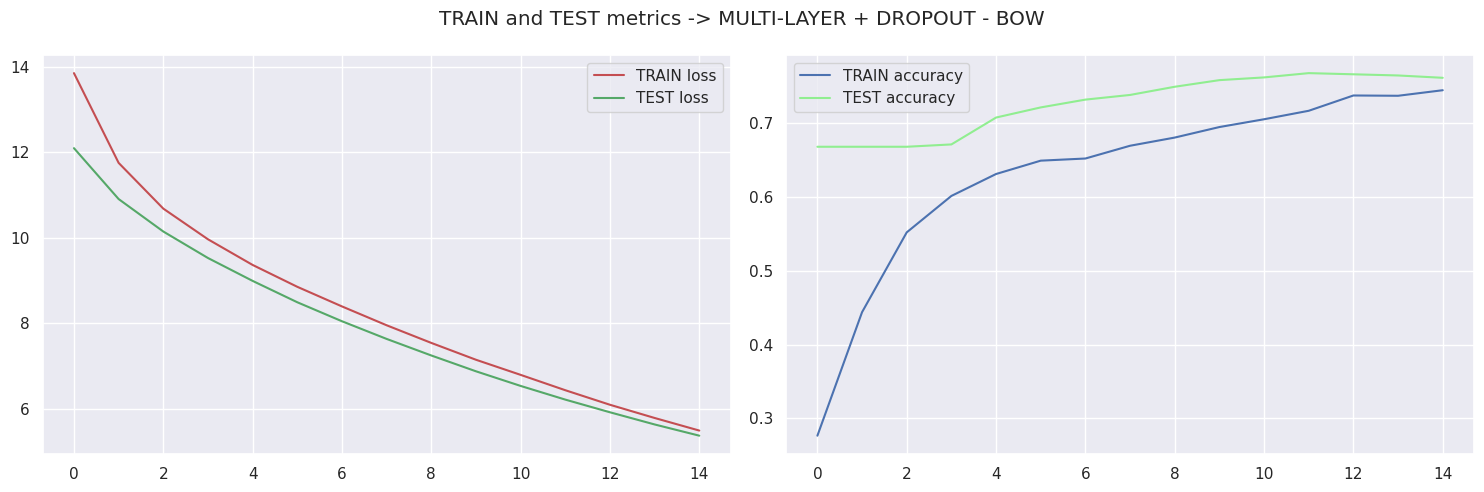



CONFUSION MATRIX: 
[[1529    0    0  104]
 [ 138    0    0   13]
 [  55    0    2   25]
 [ 229    0    0  274]]


REPORT: 
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1633
           1       0.00      0.00      0.00       151
           2       1.00      0.02      0.05        82
           3       0.66      0.54      0.60       503

    accuracy                           0.76      2369
   macro avg       0.61      0.38      0.37      2369
weighted avg       0.71      0.76      0.72      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.06368646662584201,
    "far": 0.5733695652173914
  },
  "1": {
    "frr": 1.0,
    "far": 0.0
  },
  "2": {
    "frr": 0.975609756097561,
    "far": 0.0
  },
  "3": {
    "frr": 0.4552683896620278,
    "far": 0.07609860664523044
  }
}


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [136]:
model_and_report(multi_layer_dropout_tfidf_wg, 
                 multi_layer_dropout_tfidf_wg_result, 
                 X_test_tfidf_wg.toarray(), 
                 y_test, 
                 "MULTI-LAYER + DROPOUT - TFIDF - word groups")

#### Усі групи слів

In [137]:
multi_layer_dropout_tfidf_w = deep_multilayer_with_dropout_model(X_train_tfidf_w.toarray().shape)
multi_layer_dropout_tfidf_w_result = multi_layer_dropout_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

75/75 [==============================] - 0s 3ms/step
MODEL: MULTI-LAYER + DROPOUT - BOW
On TEST accuracy: 0.7479949593544006
TRAIN Accuracy: 86.263% 



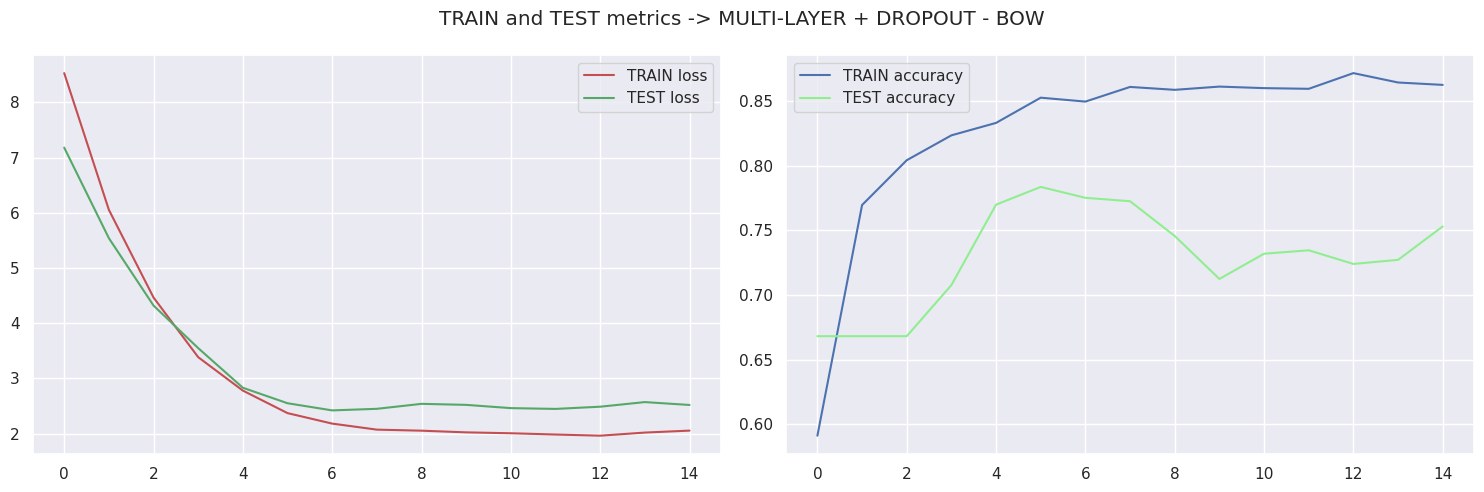



CONFUSION MATRIX: 
[[1376   75   49  133]
 [  92   33    6   20]
 [  29    1   24   28]
 [ 128   15   21  339]]


REPORT: 
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1633
           1       0.27      0.22      0.24       151
           2       0.24      0.29      0.26        82
           3       0.65      0.67      0.66       503

    accuracy                           0.75      2369
   macro avg       0.50      0.51      0.50      2369
weighted avg       0.75      0.75      0.75      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.15737905695039803,
    "far": 0.3383152173913043
  },
  "1": {
    "frr": 0.7814569536423841,
    "far": 0.04102795311091073
  },
  "2": {
    "frr": 0.7073170731707317,
    "far": 0.03323130738959335
  },
  "3": {
    "frr": 0.3260437375745527,
    "far": 0.0969989281886388
  }
}


In [139]:
model_and_report(multi_layer_dropout_tfidf_w, 
                 multi_layer_dropout_tfidf_w_result, 
                 X_test_tfidf_w.toarray(), 
                 y_test, 
                 "MULTI-LAYER + DROPOUT - BOW")

### Word2Vec

In [140]:
multi_layer_dropout_w2v = deep_multilayer_with_dropout_model(np.array(X_train_w2v_avg).shape)
multi_layer_dropout_w2v_result = multi_layer_dropout_w2v.fit(
    np.array(X_train_w2v_avg), 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=False)

75/75 [==============================] - 0s 1ms/step
MODEL: MULTI-LAYER + DROPOUT - WORD2VEC
On TEST accuracy: 0.7002955079078674
TRAIN Accuracy: 71.853% 



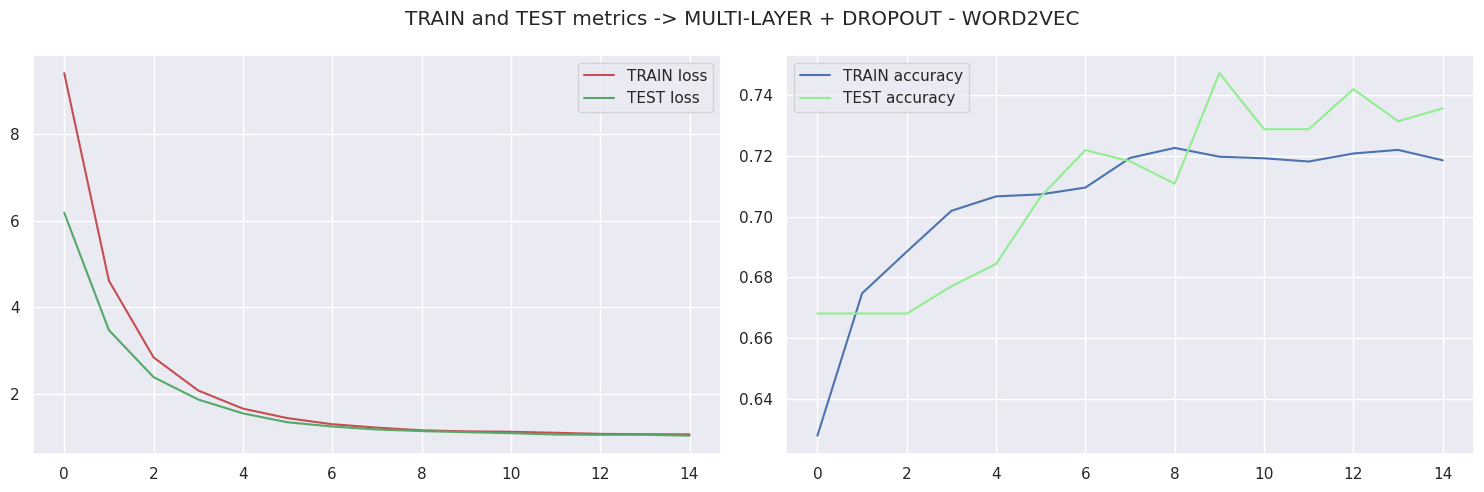



CONFUSION MATRIX: 
[[1630    0    0    3]
 [ 151    0    0    0]
 [  82    0    0    0]
 [ 474    0    0   29]]


REPORT: 
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      1633
           1       0.00      0.00      0.00       151
           2       0.00      0.00      0.00        82
           3       0.91      0.06      0.11       503

    accuracy                           0.70      2369
   macro avg       0.40      0.26      0.23      2369
weighted avg       0.67      0.70      0.59      2369


 FRR and FAR: 
{
  "0": {
    "frr": 0.001837109614206981,
    "far": 0.9605978260869565
  },
  "1": {
    "frr": 1.0,
    "far": 0.0
  },
  "2": {
    "frr": 1.0,
    "far": 0.0
  },
  "3": {
    "frr": 0.9423459244532804,
    "far": 0.001607717041800643
  }
}


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [143]:
model_and_report(multi_layer_dropout_w2v, 
                 multi_layer_dropout_w2v_result, 
                 np.array(X_test_w2v_avg), 
                 y_test, 
                 "MULTI-LAYER + DROPOUT - WORD2VEC")

## Deep CNN

In [144]:
def deep_cnn_model(input_shape, learning_rate=0.001):
    model = tf.keras.Sequential([
#         tf.keras.layers.Input(shape=(input_shape[1],)),
        tf.keras.layers.Conv1D(512, 2, activation="relu", padding="same", input_shape=(input_shape[1],1)),
        tf.keras.layers.AveragePooling1D(pool_size=3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(256, 2, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.AveragePooling1D(pool_size=3),
        tf.keras.layers.MaxPool1D(pool_size=3),
        tf.keras.layers.Conv1D(128, 2, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(64, 2, activation="relu", padding="same"),
        tf.keras.layers.AveragePooling1D(pool_size=3, padding="same"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(512, activation="relu", kernel_regularizer="l2"),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
    
    return model

## BOW

In [124]:
deep_cnn_bow = deep_cnn_model(X_train_bow.toarray().shape)
deep_cnn_bow_result = deep_cnn_bow.fit(
    X_train_bow.toarray(),
    y_train, 
    epochs=4, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=True)

Epoch 1/4
119/119 [==============================] - 559s 5s/step - loss: 0.9133 - accuracy: 0.6822 - val_loss: 1.0420 - val_accuracy: 0.6802
Epoch 2/4
119/119 [==============================] - 562s 5s/step - loss: 0.5590 - accuracy: 0.8001 - val_loss: 1.3862 - val_accuracy: 0.6802
Epoch 3/4
119/119 [==============================] - 576s 5s/step - loss: 0.3621 - accuracy: 0.8765 - val_loss: 1.8555 - val_accuracy: 0.6802
Epoch 4/4
119/119 [==============================] - 563s 5s/step - loss: 0.2365 - accuracy: 0.9224 - val_loss: 1.6539 - val_accuracy: 0.4132


75/75 [==============================] - 39s 522ms/step - loss: 1.6601 - accuracy: 0.4196
DEEP CNN - BOW
On TEST accuracy: 0.41958633065223694
TRAIN Accuracy: 92.241% 



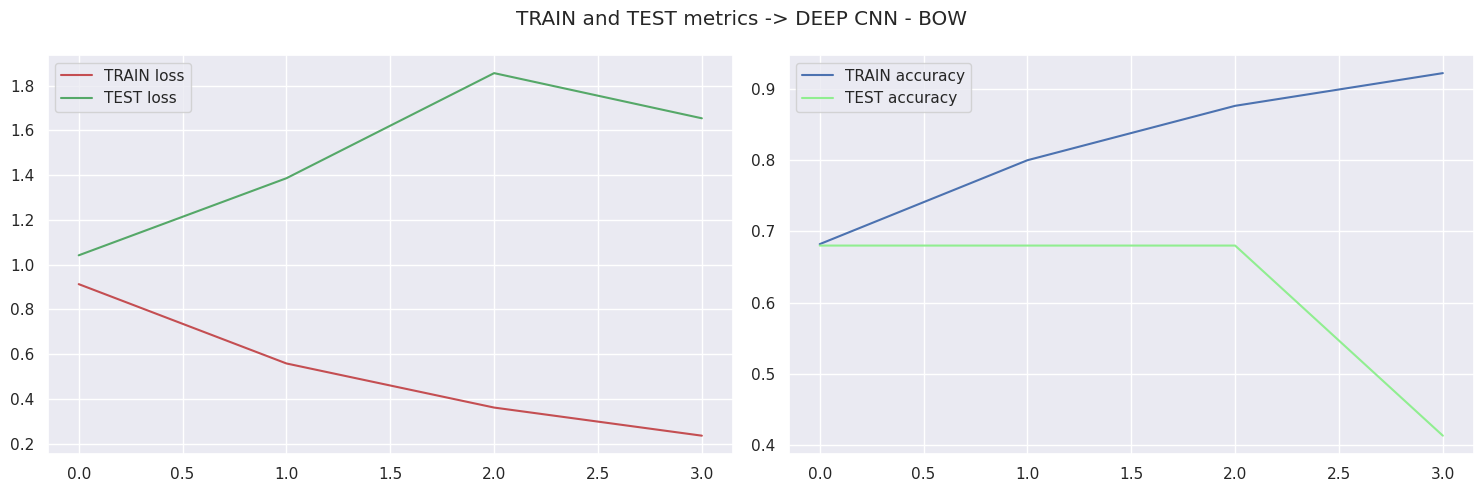



CONFUSION MATRIX
[[901 686   0   0]
 [ 59  93   0   0]
 [ 46  42   0   0]
 [281 261   0   0]]


REPORT: 
              precision    recall  f1-score   support

           0       0.70      0.57      0.63      1587
           1       0.09      0.61      0.15       152
           2       0.00      0.00      0.00        88
           3       0.00      0.00      0.00       542

    accuracy                           0.42      2369
   macro avg       0.20      0.29      0.19      2369
weighted avg       0.47      0.42      0.43      2369



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [143]:
deep_cnn_bow_y_pred = deep_cnn_bow.predict(X_test_bow.toarray(), verbose=True)
_, deep_cnn_bow_accuracy = deep_cnn_bow.evaluate(X_test_bow.toarray(), 
                                      y_test, verbose=True)

print("DEEP CNN - BOW")
print(f"On TEST accuracy: {deep_cnn_bow_accuracy}")
plot_learning_metrics(deep_cnn_bow_result, "DEEP CNN - BOW", epochs=4)

print("\n\nCONFUSION MATRIX")
print(show_confusion_matrix(y_test.argmax(axis=1), np.argmax(deep_cnn_bow_y_pred, axis=1)))

print("\n\nREPORT: ")
print(metrics.classification_report(y_test.argmax(axis=1), np.argmax(deep_cnn_bow_y_pred, axis=1)))

### Char n-grams CNN

In [145]:
AUTOTUNE = tf.data.AUTOTUNE
def configure_dataset(dataset):
    return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [146]:
X_train_tfidf_rc_optim = configure_dataset(tf.data.Dataset.from_tensor_slices(X_train_tfidf_rc.toarray()))

2023-05-06 14:13:55.308323: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10980950032 exceeds 10% of free system memory.


<9473x47049 sparse matrix of type '<class 'numpy.float64'>'
	with 2574682 stored elements in Compressed Sparse Row format>

In [ ]:
# X_train_tfidf_rc, X_test_tfidf_rc,
deep_cnn_tfidf_c = deep_cnn_model(X_train_tfidf_c.toarray().shape)
deep_cnn_tfidf_c_result = deep_cnn_tfidf_c.fit(
    X_train_tfidf_c.toarray(),
    y_train, 
    epochs=4, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    verbose=True)

In [ ]:
deep_cnn_bow_y_pred = deep_cnn_bow.predict(X_test_bow.toarray(), verbose=True)
_, deep_cnn_bow_accuracy = deep_cnn_bow.evaluate(X_test_bow.toarray(), 
                                      y_test, verbose=True)

print("DEEP CNN - BOW")
print(f"On TEST accuracy: {deep_cnn_bow_accuracy}")
plot_learning_metrics(deep_cnn_bow_result, "DEEP CNN - BOW", epochs=4)

print("\n\nCONFUSION MATRIX")
print(show_confusion_matrix(y_test.argmax(axis=1), np.argmax(deep_cnn_bow_y_pred, axis=1)))

print("\n\nREPORT: ")
print(metrics.classification_report(y_test.argmax(axis=1), np.argmax(deep_cnn_bow_y_pred, axis=1)))

### TF-IDF

#### Тільки словосполучення

In [ ]:
deep_cnn_tfidf_wg = deep_multilayer_with_dropout_model(X_train_tfidf_wg.toarray().shape)
deep_cnn_tfidf_wg_result = deep_cnn_tfidf_wg.fit(
    X_train_tfidf_wg.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

In [ ]:
_, deep_cnn_tfidf_wg_accuracy = deep_cnn_tfidf_wg.evaluate(X_test_tfidf_wg.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("CNN - TF-IDF WG")
print(f"On TEST accuracy: {deep_cnn_tfidf_wg_accuracy}")
plot_learning_metrics(deep_cnn_tfidf_wg_result, "CNN WG")

#### Усі групи слів

In [ ]:
deep_cnn_tfidf_w = deep_multilayer_with_dropout_model(X_train_tfidf_w.toarray().shape)
deep_cnn_tfidf_w_result = deep_cnn_tfidf_w.fit(
    X_train_tfidf_w.toarray(), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

In [ ]:
_, deep_cnn_tfidf_w_accuracy = deep_cnn_tfidf_w.evaluate(X_test_tfidf_w.toarray(), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("CNN - TF-IDF")
print(f"On TEST accuracy: {deep_cnn_tfidf_w_accuracy}")
plot_learning_metrics(deep_cnn_tfidf_w_result, "CNN")

### Word2vec

In [ ]:
deep_cnn_w2v = deep_cnn_model(np.array(X_train_w2v_avg).shape, learning_rate=0.00001)
deep_cnn_w2v_result = deep_cnn_w2v.fit(
    np.array(X_train_w2v_avg), 
    df_train_tf["max_reactions_category"].to_numpy(), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    verbose=True)

In [ ]:
_, deep_cnn_w2v_accuracy = deep_cnn_w2v.evaluate(np.array(X_test_w2v_avg), 
                                      df_test_tf["max_reactions_category"].to_numpy(), verbose=False)
print("MULTILAYER CNN - Word2Vec")
print(f"On TEST accuracy: {deep_cnn_w2v_accuracy}")
plot_learning_metrics(deep_cnn_w2v_result, "MULTILAYER CNN - Word2Vec")